This kernel explores details of the training data to find out interesting insights in the data and lead ideas for feature engineering.

In [1]:
# http://www.seagulls.jp/guide/rule/index.html
# https://second-effort.com/term/snap/
# https://stackoverflow.com/questions/3096953/how-to-calculate-the-time-interval-between-two-time-strings
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders
import seaborn as sns
import pandas_profiling as pdp
from datetime import datetime
import tqdm
import category_encoders as ce
import matplotlib.patches as patches
import math
pd.set_option("display.max_columns",1000)

In [2]:
env = nflrush.make_env()

In [3]:
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)

At first, let's check the contents of training data. The training data includes 509762 plays and 49 variables such as GameId and PlayId.

In [4]:
print(train_df.shape)
train_df.head(2)

(509762, 49)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


The following command checks data type of each variable in the data. 15 int variables, 24 object variables and 10 float variables.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

# Data cleaning
Before EDA, preprocessing is necessary because there's inconsistency in the data.

In [6]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

# data cleaning 
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train_df['PossessionTeam'].unique():
    map_abbr[abb] = abb
train_df['PossessionTeam'] = train_df['PossessionTeam'].map(map_abbr)
train_df['HomeTeamAbbr'] = train_df['HomeTeamAbbr'].map(map_abbr)
train_df['VisitorTeamAbbr'] = train_df['VisitorTeamAbbr'].map(map_abbr)

# offense formation
train_df["OffenseFormation"] = train_df["OffenseFormation"].fillna("Unknown") 

# Stadium
train_df["Stadium"] = train_df["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))

# Location
train_df["Location"] = train_df["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))

# Turf
train_df["Turf"] = train_df["Turf"].map(lambda x: "Artificial" if x == "Artifical"
                                       else ("Field Turf" if x == "FieldTurf" or x == "Field turf"
                                       else ("FieldTurf 360" if x == "FieldTurf360"
                                       else ("Natural Grass" if x == "natural grass" or x == "Naturall Grass" or x == "Natural grass" or x == "Natural"
                                       else ("Grass" if x == "grass"
                                       else ("UBU Speed Series-S5-M" if x == "UBU Sports Speed S5-M" else x))))))

# Player Height
train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

# stadium type
outdoor =['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
         'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']
indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed',
                   'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']
indoor_open = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
dome_closed = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
dome_open = ['Domed, Open', 'Domed, open']

train_df['StadiumType'] = train_df['StadiumType'].apply(lambda x: "outdoor" if x in outdoor 
                                                         else ("indoor closed" if x in indoor_closed
                                                        else ("indoor open" if x in indoor_open
                                                        else ("dome_closed" if x in dome_closed
                                                        else ("dome_open" if x in dome_open else "unknown")))))

# Game weather
rain = ['Rainy', 'Rain Chance 40%', 'Showers',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']
overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
              'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
              'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
              'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
              'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
              'Partly Cloudy', 'Cloudy']
clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
           'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
           'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
           'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']
snow = ['Heavy lake effect snow', 'Snow']
none = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']

train_df['GameWeather'] = train_df['GameWeather'].apply(lambda x: "rain" if x in rain 
                                                         else ("overcast" if x in overcast
                                                        else ("clear" if x in clear
                                                        else ("snow" if x in snow
                                                        else ("indoor" if x in none else "unknown")))))

# wind speed
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(str_to_float)

# wind direction
train_df['WindDirection'] = train_df['WindDirection'].apply(lambda x: "north" if x == "N" or x == "FROM S"
                                                   else ("south" if x == 'S' or x== 'FROM N'
                                                   else ("west" if x == 'W' or x == 'FROM E'
                                                   else ("east" if x == 'E' or x == 'FROM W'
                                                   else ("north east" if x == 'FROM SW' or x == 'FROM SSW' or x == 'FROM WSW'
                                                   else ("north west" if x == 'FROM SE' or x == 'FROM SSE' or x == 'FROM ESE'
                                                   else ("south east" if x == 'FROM NW' or x == 'FROM NNW' or x == 'FROM WNW'
                                                   else ("south west" if x == 'FROM NE' or x == 'FROM NNE' or x == 'FROM ENE'
                                                   else ("north west" if x == 'NW' or x == 'NORTHWEST'
                                                   else ("north east" if x == 'NE' or x == 'NORTH EAST'
                                                   else ("south west" if x == 'SW' or x == 'SOUTHWEST'
                                                   else ("south east" if x == 'SE' or x == 'SOUTHEAST' else "unknown"))))))))))))

# リーグ地区分け
afc_east = ["NE", "BUF", "NYJ", "MIA"]
afc_north = ["BLT", "CLV", "PIT", "CIN"]
afc_south = ["JAX", "HST", "TEN", "IND"]
afc_west = ["LAC", "DEN", "OAK", "KC"]

nfc_east = ["DAL", "PHI", "NYG", "WAS"]
nfc_north = ["MIN", "CHI", "DET", "GB"]
nfc_south = ["NO", "ATL", "TB", "CAR"]
nfc_west = ["SEA","LA", "SF", "ARZ"]     

#train_df['HomeTeamLeague'] = train_df['HomeTeamAbbr'].apply(lambda x: "AFC" if x in afc_east or x in afc_north or x in afc_south or x in afc_west else "NFC")
#train_df['VisitorTeamLeague'] = train_df['VisitorTeamAbbr'].apply(lambda x: "AFC" if x in afc_east or x in afc_north or x in afc_south or x in afc_west else "NFC")
train_df['HomeTeamDivision'] = train_df['HomeTeamAbbr'].apply(lambda x: "AFC_east" if x in afc_east 
                                                              else ("AFC_north" if x in afc_north 
                                                              else ("AFC_south" if x in afc_south 
                                                              else ("AFC_west" if x in afc_west
                                                              else ("NFC_east" if x in nfc_east
                                                              else ("NFC_north" if x in nfc_north 
                                                              else ("NFC_south" if x in nfc_south 
                                                              else "NFC_west"    )))))))
train_df['VisitorTeamDivision'] = train_df['VisitorTeamAbbr'].apply(lambda x: "AFC_east" if x in afc_east 
                                                              else ("AFC_north" if x in afc_north 
                                                              else ("AFC_south" if x in afc_south 
                                                              else ("AFC_west" if x in afc_west
                                                              else ("NFC_east" if x in nfc_east
                                                              else ("NFC_north" if x in nfc_north 
                                                              else ("NFC_south" if x in nfc_south 
                                                              else "NFC_west"    )))))))

# create new features
train_df['DefendersInTheBox_vs_Distance'] = train_df['DefendersInTheBox'] / train_df['Distance']
train_df['IsRusher'] = train_df['NflId'] == train_df['NflIdRusher'] # ボールをもっているかどうか
train_df["Margin"] = (train_df["HomeScoreBeforePlay"] - train_df["VisitorScoreBeforePlay"]) + 2 * (1 - (train_df["PossessionTeam"] == train_df["HomeTeamAbbr"]).astype(int)) * (train_df["VisitorScoreBeforePlay"] - train_df["HomeScoreBeforePlay"])
train_df["FieldvsPosession"] = train_df["FieldPosition"] == train_df["PossessionTeam"]

In [7]:
train_2017 = train_df[train_df.Season==2017]
train_2018 = train_df[train_df.Season==2018]

# univariate analysis
At first, we check the distribution of each variable without considering dependencies between variables. As you can see, all variables are non-negative.

In [8]:
train_df.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed,DefendersInTheBox_vs_Distance,Margin
count,5.097620e+05,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509744.000000,509748.000000,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,5.097620e+05,509696.000000,509762.000000,509762.000000,509762.000000,509762.000000,461230.000000,503602.000000,442332.000000,509696.000000,509762.000000
mean,2.017594e+09,2.017594e+13,60.040304,26.783535,2.591912,1.683176,0.279406,180.247779,179.933859,2.344703e+06,54.187982,2017.486427,28.368737,2.504639,1.520651,8.329248,11.148073,9.501057,2.419204e+06,6.943025,4.212334,74.392777,253.554388,9.096370,60.436442,55.646062,7.388342,1.519602,0.847827
std,4.997098e+05,4.997098e+09,25.435261,7.238206,1.383601,0.976412,0.145482,104.298330,106.319488,6.418871e+05,28.379359,0.499816,13.010918,1.144105,0.674987,3.795208,10.277098,9.366413,5.357783e+05,0.991130,6.436167,2.602712,48.367386,5.000984,17.570291,25.430976,4.446068,2.021514,10.767393
min,2.017091e+09,2.017091e+13,0.660000,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,1.000000,-14.000000,66.000000,153.000000,1.000000,9.000000,0.000000,-1.000000,0.035714,-44.000000
25%,2.017111e+09,2.017111e+13,39.090000,22.730000,1.500000,0.940000,0.170000,90.630000,89.830000,2.532865e+06,26.000000,2017.000000,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.540011e+06,6.000000,1.000000,72.000000,210.000000,5.000000,48.000000,43.000000,4.000000,0.600000,-5.000000
50%,2.017123e+09,2.017123e+13,60.290000,26.790000,2.470000,1.540000,0.270000,179.700000,180.090000,2.543765e+06,56.000000,2017.000000,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.552582e+06,7.000000,3.000000,75.000000,245.000000,9.000000,62.000000,59.000000,7.000000,0.700000,0.000000
75%,2.018110e+09,2.018110e+13,80.970000,30.860000,3.560000,2.290000,0.390000,270.400000,270.190000,2.555343e+06,78.000000,2018.000000,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.557976e+06,8.000000,6.000000,76.000000,305.000000,14.000000,73.000000,71.000000,10.000000,1.166667,7.000000
max,2.018123e+09,2.018123e+13,116.840000,56.450000,9.410000,14.710000,1.390000,360.000000,360.000000,2.561671e+06,99.000000,2018.000000,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.561468e+06,11.000000,99.000000,81.000000,380.000000,17.000000,97.000000,100.000000,24.000000,11.000000,44.000000


In [9]:
train_2017.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed,DefendersInTheBox_vs_Distance,Margin
count,2.618000e+05,2.618000e+05,261800.000000,261800.000000,261800.000000,261800.000000,261800.000000,261796.000000,261800.000000,2.618000e+05,261800.000000,261800.0,261800.000000,261800.000000,261800.000000,261800.000000,261800.000000,261800.000000,2.618000e+05,261756.000000,261800.000000,261800.000000,261800.000000,261800.000000,235312.000000,261800.000000,225038.000000,261756.000000,261800.000000
mean,2.017108e+09,2.017108e+13,60.319245,26.772554,2.435520,1.589579,0.280985,180.841511,179.857537,2.309017e+06,54.512177,2017.0,28.520924,2.504622,1.520504,8.379496,10.674454,9.131429,2.363467e+06,7.032022,4.015966,74.392166,254.193636,9.104118,60.503085,53.068151,7.556750,1.523000,0.938655
std,1.107494e+04,1.107494e+08,25.270983,7.253080,1.292962,0.879511,0.145852,110.125723,106.576233,6.897759e+05,28.372068,0.0,12.968603,1.142340,0.675129,3.769926,9.883503,9.115359,6.348893e+05,0.998016,6.235577,2.594245,48.051242,4.991953,18.546283,25.853576,4.571183,2.042830,10.485533
min,2.017091e+09,2.017091e+13,0.660000,2.690000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,3.000000,-14.000000,66.000000,153.000000,1.000000,9.000000,0.000000,-1.000000,0.090909,-44.000000
25%,2.017101e+09,2.017101e+13,39.540000,22.730000,1.410000,0.890000,0.170000,94.780000,89.720000,2.508044e+06,27.000000,2017.0,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.533034e+06,6.000000,1.000000,72.000000,210.000000,5.000000,48.000000,42.000000,4.000000,0.700000,-4.000000
50%,2.017111e+09,2.017111e+13,60.850000,26.790000,2.320000,1.480000,0.280000,179.910000,180.060000,2.543477e+06,57.000000,2017.0,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.550481e+06,7.000000,3.000000,75.000000,246.000000,9.000000,64.000000,57.000000,7.000000,0.700000,0.000000
75%,2.017121e+09,2.017121e+13,81.120000,30.840000,3.370000,2.200000,0.390000,274.050000,269.840000,2.555155e+06,78.000000,2017.0,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.555432e+06,8.000000,5.000000,76.000000,305.000000,14.000000,73.000000,70.000000,10.000000,1.142857,7.000000
max,2.017123e+09,2.017123e+13,116.840000,49.870000,9.010000,6.880000,1.390000,360.000000,360.000000,2.559372e+06,99.000000,2017.0,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.559325e+06,11.000000,90.000000,81.000000,380.000000,17.000000,91.000000,100.000000,24.000000,11.000000,44.000000


In [10]:
train_2018.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed,DefendersInTheBox_vs_Distance,Margin
count,2.479620e+05,2.479620e+05,247962.000000,247962.000000,247962.000000,247962.000000,247962.000000,247948.000000,247948.000000,2.479620e+05,247962.000000,247962.0,247962.000000,247962.000000,247962.000000,247962.000000,247962.000000,247962.000000,2.479620e+05,247940.000000,247962.000000,247962.000000,247962.000000,247962.000000,225918.000000,241802.000000,217294.000000,247940.000000,247962.00000
mean,2.018108e+09,2.018108e+13,59.745797,26.795129,2.757032,1.781995,0.277738,179.620887,180.014445,2.382381e+06,53.845694,2018.0,28.208056,2.504658,1.520806,8.276196,11.648124,9.891314,2.478051e+06,6.849068,4.419661,74.393423,252.879465,9.088191,60.367027,58.437176,7.213931,1.516014,0.75193
std,1.148259e+04,1.148259e+08,25.604317,7.222465,1.455132,1.060306,0.145072,97.765534,106.047880,5.847444e+05,28.383094,0.0,13.053546,1.145968,0.674838,3.821009,10.654117,9.608973,3.972600e+05,0.975035,6.635088,2.611626,48.689936,5.010498,16.492175,24.663460,4.305742,1.998761,11.05640
min,2.018091e+09,2.018091e+13,2.530000,1.850000,0.000000,0.000000,0.000000,0.010000,0.000000,2.380000e+02,1.000000,2018.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.250000e+02,1.000000,-12.000000,66.000000,159.000000,1.000000,25.000000,0.000000,-1.000000,0.035714,-44.00000
25%,2.018101e+09,2.018101e+13,38.610000,22.720000,1.610000,0.990000,0.160000,90.000000,89.940000,2.533050e+06,26.000000,2018.0,19.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.543743e+06,6.000000,1.000000,72.000000,210.000000,5.000000,46.000000,47.000000,4.000000,0.600000,-6.00000
50%,2.018110e+09,2.018110e+13,59.700000,26.800000,2.630000,1.610000,0.270000,178.370000,180.110000,2.552265e+06,55.000000,2018.0,29.000000,3.000000,1.000000,10.000000,10.000000,7.000000,2.555430e+06,7.000000,3.000000,75.000000,245.000000,9.000000,61.000000,62.000000,6.000000,0.700000,0.00000
75%,2.018121e+09,2.018121e+13,80.820000,30.890000,3.790000,2.400000,0.380000,269.840000,270.510000,2.556827e+06,78.000000,2018.0,39.000000,4.000000,2.000000,10.000000,17.000000,16.000000,2.558250e+06,7.000000,6.000000,76.000000,305.000000,14.000000,73.000000,75.000000,10.000000,1.166667,7.00000
max,2.018123e+09,2.018123e+13,116.790000,56.450000,9.410000,14.710000,1.130000,360.000000,360.000000,2.561671e+06,99.000000,2018.0,50.000000,5.000000,4.000000,40.000000,52.000000,51.000000,2.561468e+06,11.000000,99.000000,81.000000,380.000000,17.000000,97.000000,100.000000,22.000000,11.000000,44.00000


In [11]:
# standard deviation
std_zero_feature = []
for i in [i for i in train_df.columns if train_df[i].dtype != "object"]:
    if train_df[i].std() == 0:
        std_zero_feature.append(i)
print("std zero features: {}" .format(len(std_zero_feature))) 

std zero features: 0


In [12]:
# missing values (includes 8 missing values. possibly, the values of FieldPosition and DefendersInTheBox can be calculated?)
missing_df = train_df.isnull().sum()
print(missing_df[missing_df > 0])

missing_2017 = train_2017.isnull().sum()
print(missing_2017[missing_2017 > 0])

missing_2018 = train_2018.isnull().sum()
print(missing_2018[missing_2018 > 0])

Orientation                         18
Dir                                 14
FieldPosition                     6424
DefendersInTheBox                   66
Temperature                      48532
Humidity                          6160
WindSpeed                        67430
DefendersInTheBox_vs_Distance       66
dtype: int64
Orientation                          4
FieldPosition                     3300
DefendersInTheBox                   44
Temperature                      26488
WindSpeed                        36762
DefendersInTheBox_vs_Distance       44
dtype: int64
Orientation                         14
Dir                                 14
FieldPosition                     3124
DefendersInTheBox                   22
Temperature                      22044
Humidity                          6160
WindSpeed                        30668
DefendersInTheBox_vs_Distance       22
dtype: int64


The distribution of yards is skewed. the median of yards is 3 yards.

3.0


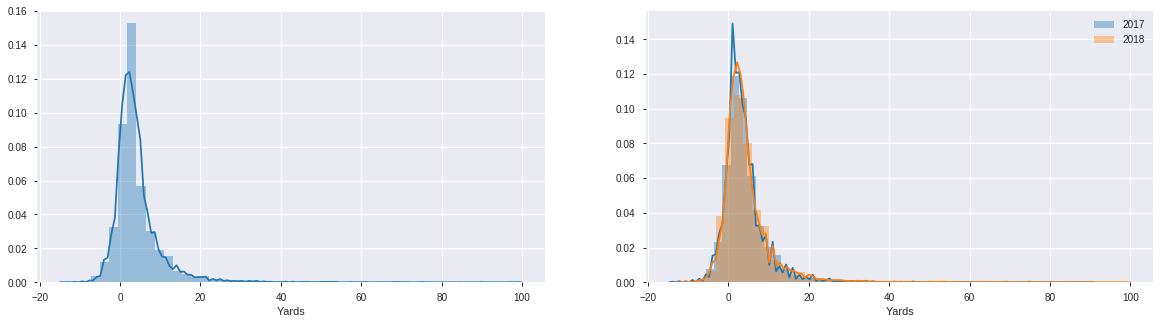

In [13]:
# yards
print(train_df["Yards"].median())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(train_df["Yards"])
plt.subplot(1,2,2)
sns.distplot(train_2017["Yards"], label="2017")
sns.distplot(train_2018["Yards"], label="2018")
plt.legend()

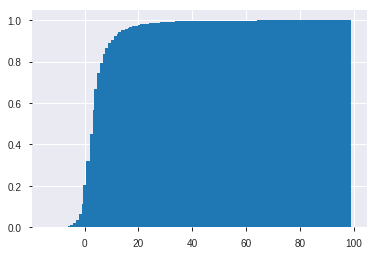

In [14]:
train = train_df.drop_duplicates(subset="PlayId") 
dist = train["Yards"].hist(density = True, cumulative = True, bins = 200)

In [15]:
train_own = train[train["FieldPosition"] == train["PossessionTeam"]]
train_other = train[train["FieldPosition"] != train["PossessionTeam"]]

own_cdf = np.histogram(train_own["Yards"], bins=199, range=(-99,100), density=True)[0].cumsum()
other_cdf = np.histogram(train_other["Yards"], bins=199, range=(-99,100), density=True)[0].cumsum()

Despite the fact that the cumulative distributions of yards seem similar, when we check the values in detail, the values are clearly different. When the value of field position and possessionteam is different, there's no chance that team progress the last 50 yards.

Text(0.5, 1.0, 'Other cdf')

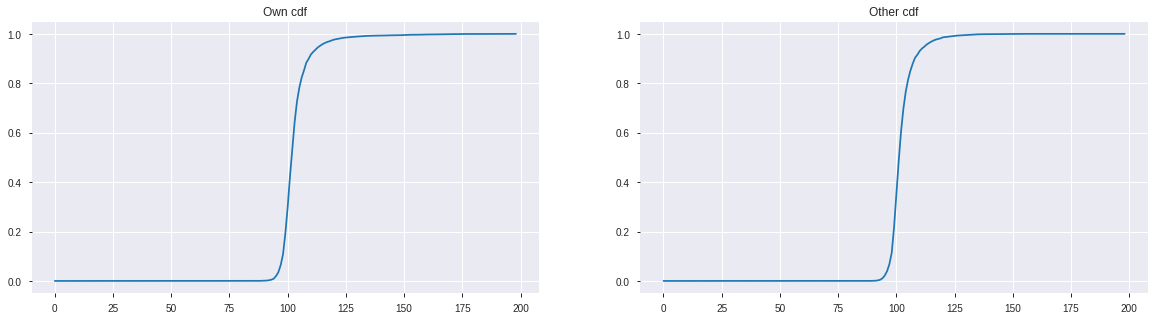

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(own_cdf)
plt.title("Own cdf")
plt.subplot(1,2,2)
plt.plot(other_cdf)
plt.title("Other cdf")

In [17]:
own_cdf

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [18]:
other_cdf

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

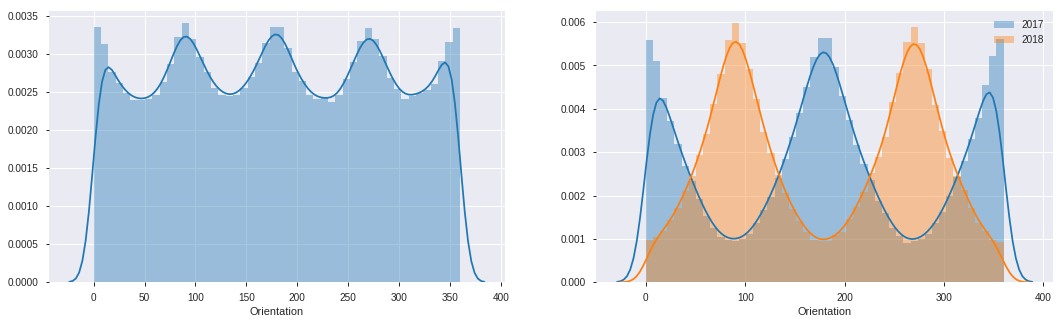

In [19]:
# Orientation: players' orientation, clear difference 
plt.figure(figsize=(18,5))
tmp_df = train_df["Orientation"].dropna()
tmp_2017 = train_2017["Orientation"].dropna()
tmp_2018 = train_2018["Orientation"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

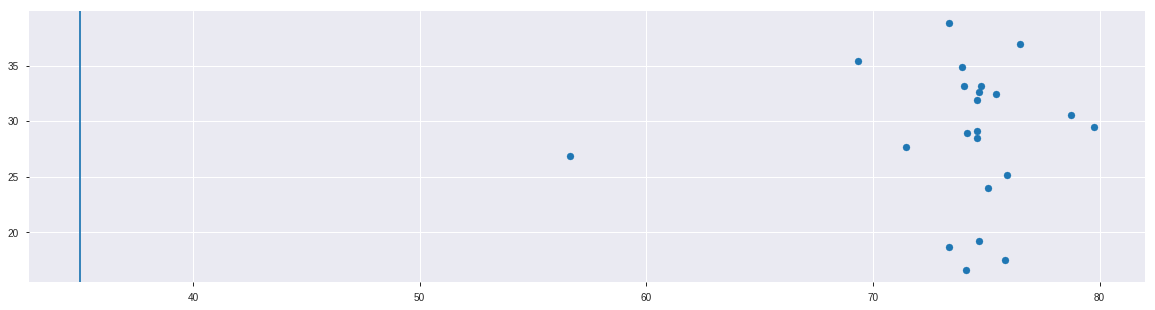

In [20]:
# X, Y: player positions
plt.figure(figsize=(20,5))
plt.scatter(train_df.iloc[0:22]["X"], train_df.iloc[0:22]["Y"])
plt.axvline(train_df.iloc[1]["YardLine"])

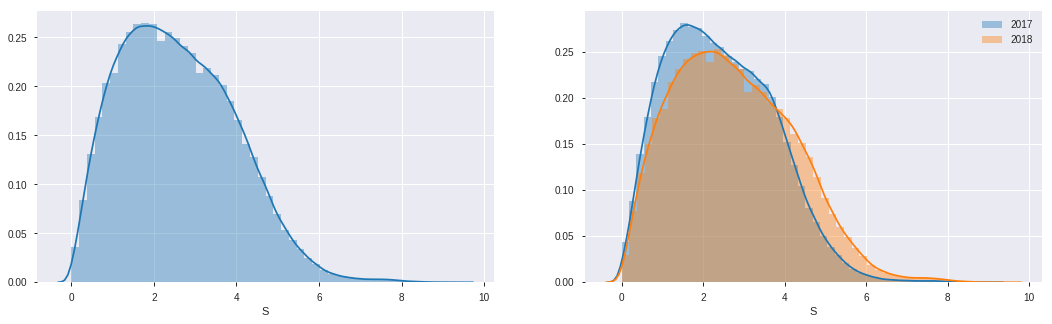

In [21]:
# S: player spped: faster in 2018 than in 2017
plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
sns.distplot(train_df[train_df.columns[5]])
plt.subplot(1, 2, 2)
sns.distplot(train_2017[train_2017.columns[5]], label = "2017")
sns.distplot(train_2018[train_2018.columns[5]], label = "2018")
plt.legend()

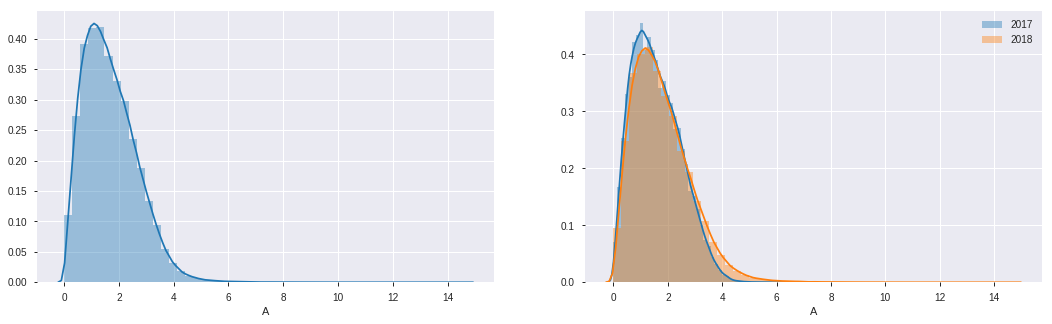

In [22]:
# A: acceleration, higher in 2018 than in 2017
plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
sns.distplot(train_df[train_df.columns[6]])
plt.subplot(1, 2, 2)
sns.distplot(train_2017[train_2017.columns[6]], label = "2017")
sns.distplot(train_2018[train_2018.columns[6]], label = "2018")
plt.legend()

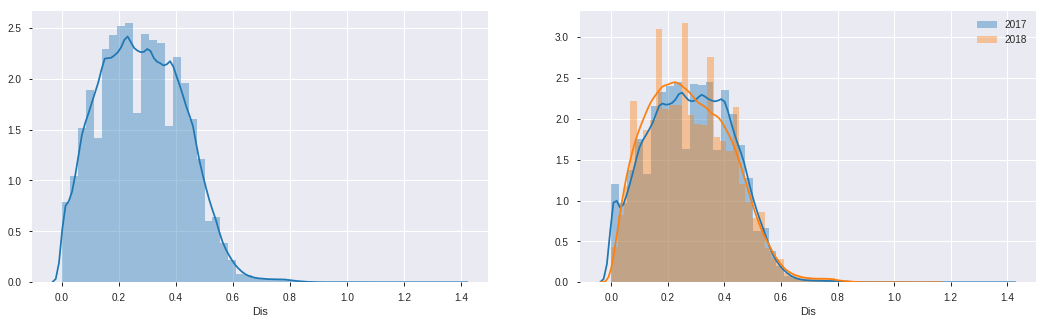

In [23]:
# Dis: 前時点のポイントから移動した距離(ヤード)
plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
sns.distplot(train_df[train_df.columns[7]])
plt.subplot(1, 2, 2)
sns.distplot(train_2017[train_2017.columns[7]], label = "2017")
sns.distplot(train_2018[train_2018.columns[7]], label = "2018")
plt.legend()

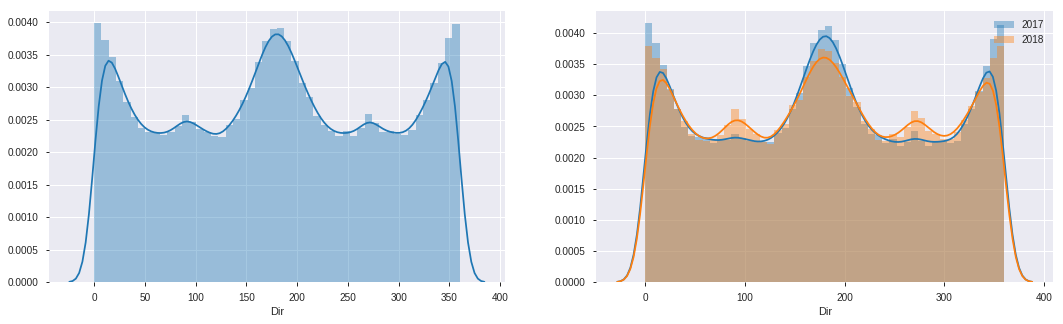

In [24]:
# Dir: angle of player motion
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[9]].dropna()
tmp_2017 = train_2017[train_2017.columns[9]].dropna()
tmp_2018 = train_2018[train_2018.columns[9]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

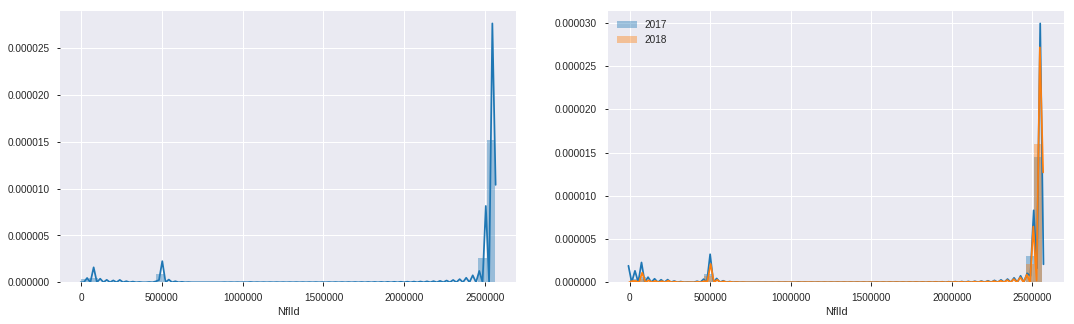

In [25]:
# nflid 
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[10]].dropna()
tmp_2017 = train_2017[train_2017.columns[10]].dropna()
tmp_2018 = train_2018[train_2018.columns[10]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()
# we do not consider the next variable because it's the name of players

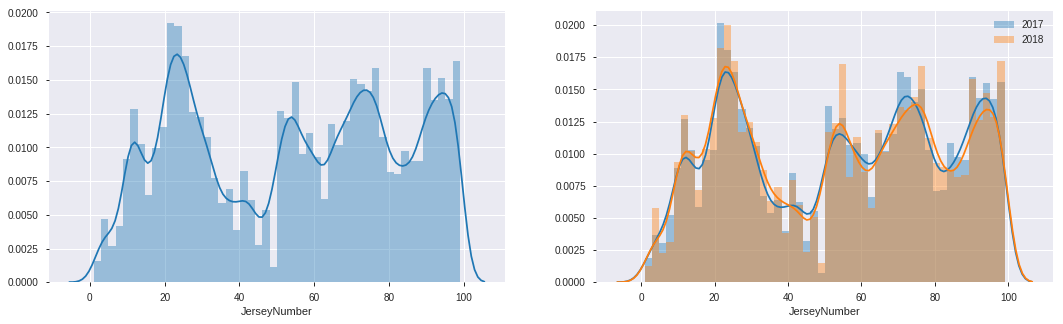

In [26]:
# Jerseynumber：　選手のジャージ番号
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[12]].dropna()
tmp_2017 = train_2017[train_2017.columns[12]].dropna()
tmp_2018 = train_2018[train_2018.columns[12]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


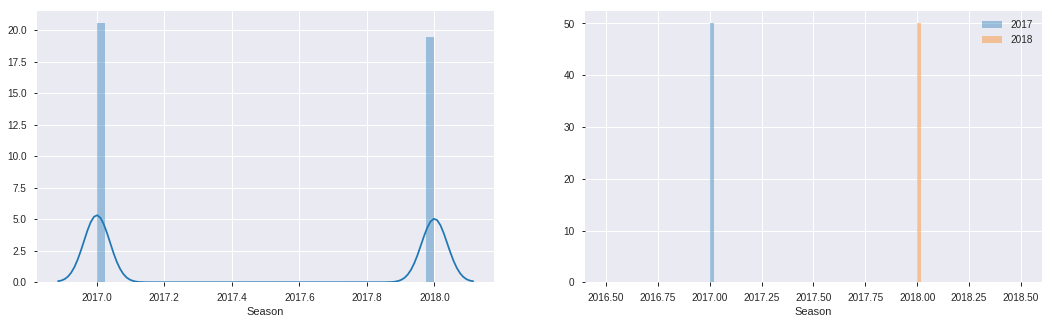

In [27]:
# season: 試合がプレーされたシーズン。2017か２０１８
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[13]].dropna()
tmp_2017 = train_2017[train_2017.columns[13]].dropna()
tmp_2018 = train_2018[train_2018.columns[13]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

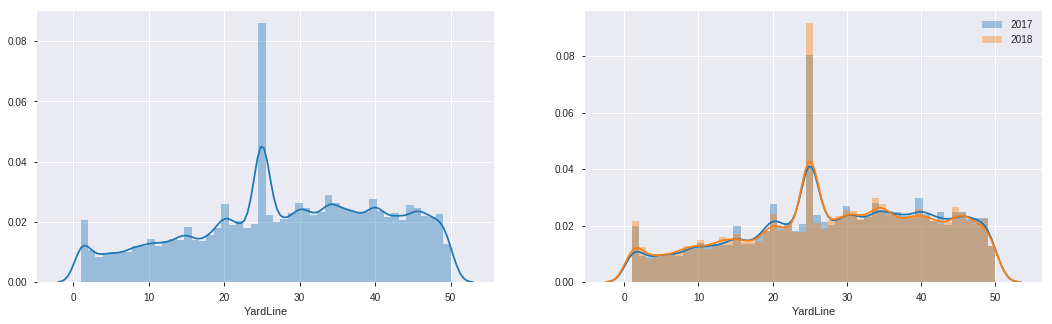

In [28]:
# yardline： アメフトのスクリメージライン（オフェンス側とディフェンス側に引かれた架空の境界線、スクリメージライン上にボールが配置され、そのボールが動いたタイミングで攻撃がスタートする）
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[14]].dropna()
tmp_2017 = train_2017[train_2017.columns[14]].dropna()
tmp_2018 = train_2018[train_2018.columns[14]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

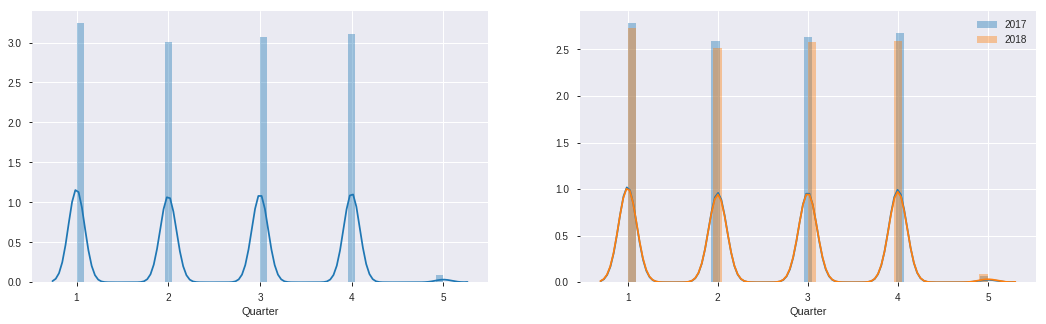

In [29]:
# quarter: 一試合は4クオーターで構成される。一部延長ラウンド(quarter 5)があったみたい。
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[15]].dropna()
tmp_2017 = train_2017[train_2017.columns[15]].dropna()
tmp_2018 = train_2018[train_2018.columns[15]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

In [30]:
# Possession team: ボールを持っているチームの名称
train_df[train_df.columns[17]].value_counts()          

NE     18700
LA     17952
BLT    17864
JAX    17490
NO     17490
SEA    17094
DAL    16918
HST    16764
MIN    16742
LAC    16698
DEN    16654
TEN    16544
PHI    16478
CHI    16368
BUF    16214
SF     16192
IND    16060
NYG    15642
DET    15554
NYJ    15532
ATL    15488
OAK    15422
PIT    15312
ARZ    15092
WAS    15092
KC     14300
CIN    14278
TB     14212
MIA    14168
CAR    14146
CLV    14102
GB     13200
Name: PossessionTeam, dtype: int64

In [31]:
# Down オフェンスの一回の攻撃のことをダウンという
train_df[train_df.columns[18]].value_counts()

1    292666
2    172986
3     39908
4      4202
Name: Down, dtype: int64

10    301752
1      41954
5      20042
2      19888
4      17930
6      17226
3      16940
7      16324
8      15642
9      13046
15      4818
11      4532
20      3960
12      3432
13      2288
14      1848
18      1452
17      1276
19      1188
16      1166
21       484
22       440
25       440
23       418
24       286
26       220
27       176
28       132
30       110
29        88
33        66
35        66
40        66
31        44
34        22
Name: Distance, dtype: int64


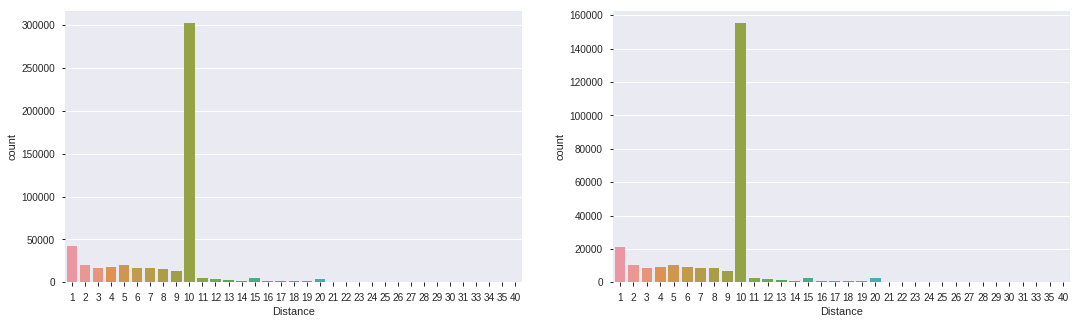

In [32]:
# Distance: ファーストダウンに必要な距離 (4回の攻撃で10ヤード以上進めば新たな攻撃権を獲得でき、これをファーストダウン獲得という)
# １０より大きな数値があるのは、攻撃が失敗して後退したため？
print(train_df[train_df.columns[19]].value_counts())

plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
sns.countplot(train_df[train_df.columns[19]])
plt.subplot(1, 2, 2)
sns.countplot(train_2017[train_2017.columns[19]])
sns.countplot(train_2018[train_2018.columns[19]])
plt.legend()

In [33]:
# fieldposition: プレーが発生したのは、どちらのサイドか
print(train_df[train_df.columns[20]].value_counts())

BUF    17468
OAK    17182
NYG    17160
ARZ    17072
MIA    16984
NYJ    16896
CLV    16676
CIN    16588
DEN    16566
SF     16456
SEA    16412
HST    16346
CHI    16060
IND    16038
TEN    15972
GB     15862
LA     15818
JAX    15620
DAL    15576
WAS    15554
DET    15444
BLT    15356
TB     15246
MIN    15158
LAC    15114
ATL    14938
KC     14784
NE     14718
PIT    14366
PHI    13442
NO     13332
CAR    13134
Name: FieldPosition, dtype: int64


0     121418
7      63514
10     41602
3      41228
14     32956
17     28754
13     18700
6      17534
20     16368
24     15114
21     13420
16     11396
9      10472
23      9724
27      8536
28      6798
31      5962
26      5038
30      4620
35      3454
15      3190
12      2860
38      2794
34      2750
19      2508
29      2156
33      1672
18      1562
45      1562
37      1518
2       1386
40      1342
42      1188
22       924
44       682
8        660
25       550
39       506
48       484
11       462
52       418
32       396
36       308
47       308
43       286
54       176
41       132
51       132
46       132
57       110
Name: HomeScoreBeforePlay, dtype: int64


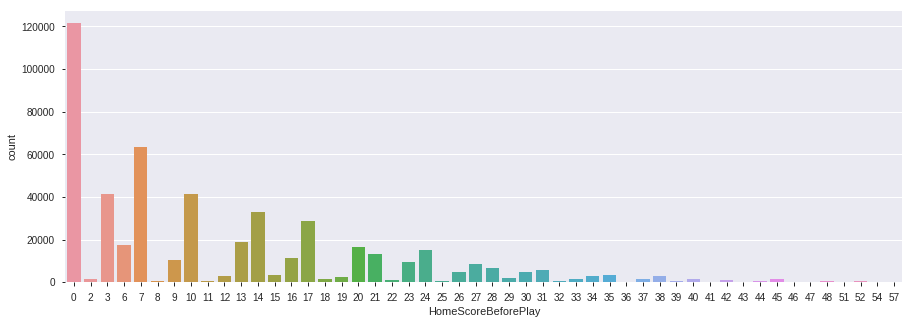

In [34]:
# homescorebeforeplay
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[21]].value_counts())
sns.countplot(train_df[train_df.columns[21]])

0     142516
7      63448
3      48532
10     41228
14     28094
17     24728
13     23012
6      21714
20     15026
21     11528
24     11154
16      9570
9       7854
23      7018
27      6930
12      5940
19      5918
28      4994
30      3740
31      3256
34      2222
35      2222
26      2178
15      1892
22      1716
2       1474
38      1408
33      1408
42       968
48       924
37       924
40       858
18       748
41       704
25       682
32       572
29       550
5        550
39       396
11       308
51       242
8        198
36       176
45       176
44        66
Name: VisitorScoreBeforePlay, dtype: int64


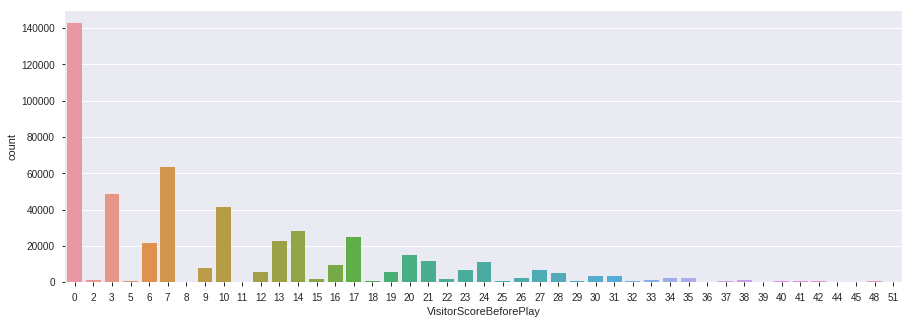

In [35]:
# visitorscorebeforeplay
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[22]].value_counts())
sns.countplot(train_df[train_df.columns[22]])

In [36]:
# NflIdrusher: ラッシュプレーをしたプレイヤーのID
print(train_df[train_df.columns[23]].value_counts())

2555224    11814
2552475    11726
2555418    11396
2552469    10010
2557917     9900
           ...  
2543477       22
2561358       22
2557863       22
2543475       22
2506931       22
Name: NflIdRusher, Length: 371, dtype: int64


In [37]:
# OffenseFormation: オフェンス時のフォーメーション
print(train_df[train_df.columns[24]].value_counts())
print(train_2017[train_2017.columns[24]].value_counts())
print(train_2018[train_2018.columns[24]].value_counts())

SINGLEBACK    225434
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
Unknown          110
ACE               22
Name: OffenseFormation, dtype: int64
SINGLEBACK    117194
SHOTGUN        71192
I_FORM         60786
JUMBO           6094
PISTOL          5940
WILDCAT          330
EMPTY            176
Unknown           66
ACE               22
Name: OffenseFormation, dtype: int64
SINGLEBACK    108240
SHOTGUN        79772
I_FORM         45276
PISTOL          7480
JUMBO           5368
WILDCAT         1452
EMPTY            330
Unknown           44
Name: OffenseFormation, dtype: int64


In [38]:
arr = [[int(s[0]) for s in t.split(", ")] for t in train_df["OffensePersonnel"]]
train_df["DL"] = np.array([a[0] for a in arr])
train_df["LB"] = np.array([a[1] for a in arr])
train_df["DB"] = np.array([a[2] for a in arr])
train_df["OL"] = np.array([a[3] if len(a) == 4 else 0 for a in arr])

In [39]:
# OffensePersonel: オフェンス側のポジションのグループわけ、上のoffenseformationと個数が一致しているわけではないみたい。
# RB, TE, WR, OL, DL, QB
print(train_df[train_df.columns[25]].value_counts())

1 RB, 1 TE, 3 WR               232958
1 RB, 2 TE, 2 WR               114092
2 RB, 1 TE, 2 WR                53636
1 RB, 3 TE, 1 WR                31306
2 RB, 2 TE, 1 WR                25828
6 OL, 1 RB, 2 TE, 1 WR           9680
6 OL, 1 RB, 1 TE, 2 WR           8426
6 OL, 2 RB, 1 TE, 1 WR           5896
6 OL, 2 RB, 2 TE, 0 WR           3762
2 RB, 0 TE, 3 WR                 3454
1 RB, 2 TE, 1 WR,1 DL            3102
6 OL, 1 RB, 0 TE, 3 WR           2178
1 RB, 0 TE, 4 WR                 1870
0 RB, 1 TE, 4 WR                 1672
2 QB, 1 RB, 1 TE, 2 WR           1562
2 RB, 3 TE, 0 WR                 1408
6 OL, 1 RB, 3 TE, 0 WR           1210
6 OL, 2 RB, 0 TE, 2 WR           1056
1 RB, 1 TE, 2 WR,1 DL             748
7 OL, 1 RB, 0 TE, 2 WR            682
3 RB, 1 TE, 1 WR                  572
2 QB, 2 RB, 1 TE, 1 WR            550
1 RB, 3 TE, 0 WR,1 DL             440
6 OL, 1 RB, 2 TE, 0 WR,1 DL       352
3 RB, 0 TE, 2 WR                  286
2 QB, 1 RB, 2 TE, 1 WR            264
7 OL, 1 RB, 

7.0     208516
6.0     152526
8.0     109362
5.0      15048
9.0      13442
10.0      4114
11.0      3652
4.0       2596
3.0        396
1.0         22
2.0         22
Name: DefendersInTheBox, dtype: int64


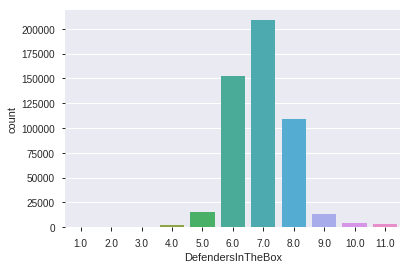

In [40]:
# defenders in the box: スクリメージラインに並んでいるディフェンダーの数 (6~8人並べているパターンが多い)
print(train_df[train_df.columns[26]].value_counts())
tmp_df = train_df[train_df.columns[26]].dropna()
sns.countplot(tmp_df)

In [41]:
# defence personnel: ディフェンスのポジショングルーピング
print(train_df[train_df.columns[27]].value_counts())
#tmp_df = train_df[train_df.columns[26]].dropna()
#sns.countplot(tmp_df)

4 DL, 2 LB, 5 DB          139876
4 DL, 3 LB, 4 DB          136510
3 DL, 4 LB, 4 DB           80432
2 DL, 4 LB, 5 DB           56936
3 DL, 3 LB, 5 DB           48884
2 DL, 3 LB, 6 DB           11638
4 DL, 1 LB, 6 DB            9196
4 DL, 4 LB, 3 DB            5214
3 DL, 2 LB, 6 DB            4246
5 DL, 2 LB, 4 DB            3542
5 DL, 3 LB, 3 DB            2376
1 DL, 4 LB, 6 DB            1430
3 DL, 5 LB, 3 DB            1408
6 DL, 4 LB, 1 DB            1232
5 DL, 4 LB, 2 DB            1166
6 DL, 3 LB, 2 DB            1034
5 DL, 1 LB, 5 DB             902
6 DL, 2 LB, 3 DB             704
1 DL, 5 LB, 5 DB             682
2 DL, 5 LB, 4 DB             484
2 DL, 2 LB, 7 DB             286
1 DL, 3 LB, 7 DB             286
3 DL, 1 LB, 7 DB             264
5 DL, 3 LB, 2 DB, 1 OL       154
5 DL, 5 LB, 1 DB             154
0 DL, 5 LB, 6 DB             132
4 DL, 5 LB, 2 DB             110
0 DL, 4 LB, 7 DB              88
2 DL, 4 LB, 4 DB, 1 OL        66
5 DL, 4 LB, 1 DB, 1 OL        66
4 DL, 0 LB

In [42]:
# play direction: プレーされている方向　右がXが増える方向で、左がXが減る方向とする
print(train_df[train_df.columns[28]].value_counts())
print(train_2017[train_2017.columns[28]].value_counts())
print(train_2018[train_2018.columns[28]].value_counts())

left     256454
right    253308
Name: PlayDirection, dtype: int64
right    131472
left     130328
Name: PlayDirection, dtype: int64
left     126126
right    121836
Name: PlayDirection, dtype: int64


In [43]:
# time hand off: ハンドオフの時間。(ハンドオフとは、ランプレイの時に、クオーターバックから、ランニングバックに手渡しされることを意味する。雨天時は、ファンブルを避けるため多く採用される傾向らしい)
print(train_df[train_df.columns[29]].value_counts())

2018-10-07T17:17:43.000Z    66
2018-12-30T22:06:01.000Z    44
2018-12-23T20:07:19.000Z    44
2018-10-07T18:19:07.000Z    44
2017-10-22T19:29:09.000Z    44
                            ..
2018-10-21T19:29:03.000Z    22
2017-10-29T18:13:35.000Z    22
2017-12-03T18:40:54.000Z    22
2017-10-22T21:35:18.000Z    22
2018-12-02T20:02:54.000Z    22
Name: TimeHandoff, Length: 22935, dtype: int64


In [44]:
# time snap: スナップの時間 （スナップ:攻撃時センターからクオータバックの掛け声にしたがって、ボールを出すこと。) スナップ→ハンドオフとなる。
print(train_df[train_df.columns[30]].value_counts())

2017-12-31T21:55:29.000Z    66
2018-10-07T17:17:41.000Z    66
2018-10-07T17:05:39.000Z    44
2017-11-12T20:16:49.000Z    44
2017-09-17T17:18:15.000Z    44
                            ..
2018-09-10T01:25:03.000Z    22
2018-10-23T00:46:46.000Z    22
2017-10-01T19:41:16.000Z    22
2018-09-11T02:06:14.000Z    22
2018-09-30T19:18:39.000Z    22
Name: TimeSnap, Length: 22943, dtype: int64


75    81694
76    66603
77    62913
73    61729
74    52893
72    50531
71    39361
78    34650
70    24596
79    13076
69     9439
80     5653
68     3507
81     2029
67      682
66      406
Name: PlayerHeight, dtype: int64


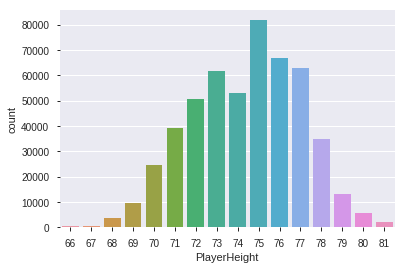

In [45]:
# Player Height: 選手の身長
print(train_df[train_df.columns[32]].value_counts())
sns.countplot(train_df[train_df.columns[32]])

315    15945
215    14377
310    14236
195    12330
305    12173
       ...  
283       39
170       26
351       24
153        5
358        4
Name: PlayerWeight, Length: 182, dtype: int64


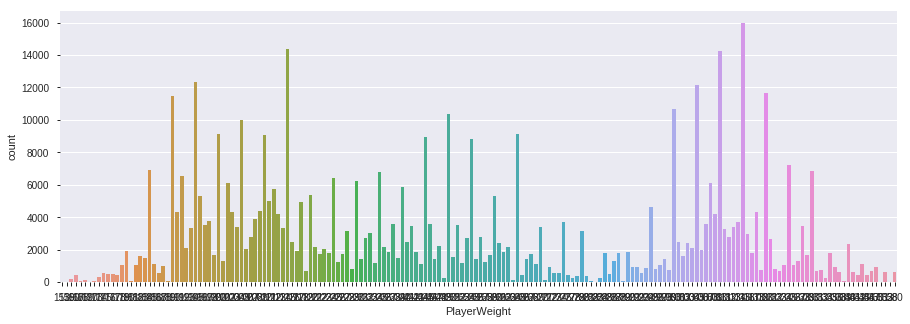

In [46]:
# Player Weight: 選手の体重
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[33]].value_counts())
sns.countplot(train_df[train_df.columns[33]])

In [47]:
# Player BirthDate: 選手の誕生日
print(train_df[train_df.columns[34]].value_counts())

04/23/1991    1602
12/29/1989    1562
05/13/1992    1556
04/26/1989    1545
06/08/1989    1458
              ... 
01/02/1993       1
01/16/1989       1
02/24/1992       1
10/16/1987       1
12/28/1994       1
Name: PlayerBirthDate, Length: 1688, dtype: int64


In [48]:
# player college name
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[35]].value_counts())

Alabama            16174
Ohio State         13984
Louisiana State    12211
Florida            11775
Georgia            11686
                   ...  
Cal Poly               3
Texas Southern         3
Stetson                2
Eastern Oregon         2
Alcorn State           1
Name: PlayerCollegeName, Length: 301, dtype: int64


<Figure size 1080x360 with 0 Axes>

In [49]:
# Position: 選手のポジション名
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[36]].value_counts())

CB     56686
WR     53325
G      42114
T      42046
DE     35890
DT     35637
OLB    34110
TE     33237
FS     24607
C      24062
RB     23908
QB     23290
SS     20540
ILB    18541
MLB    10208
NT      8226
LB      6699
OT      6097
FB      3211
OG      3073
DB      1931
S       1641
HB       647
SAF       19
DL        17
Name: Position, dtype: int64


<Figure size 1080x360 with 0 Axes>

In [50]:
# Hometeamabbr: ホームチームの略称
print(train_df[train_df.columns[37]].value_counts())
print("team no: ", len(train_df[train_df.columns[37]].unique()))

SF     17402
NYG    17336
NE     17248
BUF    17204
BLT    17094
SEA    16962
CIN    16588
IND    16544
DEN    16478
OAK    16456
ARZ    16434
NYJ    16236
MIN    16170
JAX    15972
DAL    15950
CLV    15928
HST    15884
TEN    15862
LA     15642
NO     15554
LAC    15532
MIA    15400
WAS    15356
KC     15334
CHI    15334
GB     15312
DET    15246
ATL    15246
PIT    14850
TB     14696
PHI    14476
CAR    14036
Name: HomeTeamAbbr, dtype: int64
team no:  32


In [51]:
# Visitorteamabbr: ビジターチームの略称
print(train_df[train_df.columns[38]].value_counts())
print("team no: ", len(train_df[train_df.columns[38]].unique()))

LA     17864
JAX    17072
IND    16764
LAC    16720
DEN    16698
OAK    16478
TEN    16478
WAS    16390
NYJ    16390
DET    16368
ARZ    16302
SF     16302
MIA    16236
HST    16170
NO     16038
CHI    16038
KC     15862
DAL    15840
BLT    15818
SEA    15774
MIN    15774
CIN    15708
BUF    15664
NE     15510
CLV    15422
TB     15378
NYG    15356
GB     15312
PIT    15114
ATL    15092
PHI    14168
CAR    13662
Name: VisitorTeamAbbr, dtype: int64
team no:  32


14    32692
17    32516
15    32428
16    31746
13    31636
3     31482
4     30954
1     30558
2     30316
12    30052
6     29524
7     29084
5     28886
10    28358
8     27412
11    26862
9     25256
Name: Week, dtype: int64


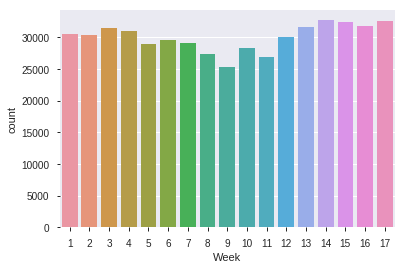

In [52]:
# Week: week into season シーズンの第何週か
print(train_df[train_df.columns[39]].value_counts())
sns.countplot(train_df[train_df.columns[39]])

In [53]:
# Stadium: スタジアム名 # 2017年だけ、または2018年しかプレイされていない球場がある
print(train_df[train_df.columns[40]].value_counts())
print(train_2017[train_2017.columns[40]].value_counts())
print(train_2018[train_2018.columns[40]].value_counts())

MetLife Stadium                        33572
Levis Stadium                          17402
Gillette Stadium                       17248
New Era Field                          17204
M&T Bank Stadium                       17094
CenturyLink Field                      16962
Paul Brown Stadium                     16588
Lucas Oil Stadium                      16544
Mercedes-Benz Superdome                16412
U.S. Bank Stadium                      16170
AT&T Stadium                           15950
NRG Stadium                            15884
Nissan Stadium                         15862
FedExField                             15356
Soldier Field                          15334
Arrowhead Stadium                      15334
Lambeau Field                          15312
Ford Field                             15246
Heinz Field                            14850
FirstEnergy Stadium                    14828
Raymond James Stadium                  14696
Los Angeles Memorial Coliseum          14674
StubHub Ce

In [54]:
print(set(train_2018[train_2018.columns[40]].unique()) - set(train_2017[train_2017.columns[40]].unique()))
print(set(train_2017[train_2017.columns[40]].unique()) - set(train_2018[train_2018.columns[40]].unique()))

{'State Farm Stadium', 'Broncos Stadium at Mile High', 'TIAA Bank Field'}
{'Twickenham Stadium', 'Estadio Azteca', 'University of Phoenix Stadium', 'Everbank Field', 'Sports Authority Field at Mile High'}


In [55]:
# Location
print(train_df[train_df.columns[41]].value_counts())

East Rutherford, NJ    33572
Santa Clara, CA        17402
Foxborough, MA         17248
Orchard Park, NY       17204
Baltimore, MD          17094
Seattle, WA            16962
Cincinnati, OH         16588
Indianapolis, Ind.     16544
Denver, CO             16478
Glendale, AZ           16434
Minneapolis, MN        16170
Arlington, TX          15950
Houston, TX            15884
Nashville, TN          15862
New Orleans, LA        15554
Landover, MD           15356
Chicago, IL            15334
Green Bay, WI          15312
Atlanta, GA            15246
Detroit, MI            15246
Pittsburgh, PA         14850
Cleveland, OH          14828
Tampa, FL              14696
Los Angeles, CA        14674
Carson, CA             14630
Miami Gardens, FLA     14564
Oakland, CA            14564
Philadelphia, PA       14476
Kansas City, MO        14190
Jacksonville, FL       14124
Charlotte, NC          14036
London                  6644
Kansas City,  MO        1144
Mexico City              902
Name: Location

In [56]:
# stadium type
print(train_df[train_df.columns[42]].value_counts())

outdoor          343376
indoor closed     88616
unknown           32934
dome_closed       29040
indoor open       12342
dome_open          3454
Name: StadiumType, dtype: int64


In [57]:
# Turf: スタジアムの芝の種類
print(train_df[train_df.columns[43]].value_counts())

Grass                     167090
Natural Grass             115192
Field Turf                 81862
Artificial                 48378
UBU Speed Series-S5-M      41448
A-Turf Titan               17204
FieldTurf 360              15246
DD GrassMaster              8074
Twenty-Four/Seven Turf      8030
SISGrass                    7238
Name: Turf, dtype: int64


In [58]:
# GameWeather: 天気
print(train_df[train_df.columns[44]].value_counts())

overcast    204380
clear       189156
unknown      44440
indoor       39490
rain         28424
snow          3872
Name: GameWeather, dtype: int64


68.0    27236
72.0    14432
61.0    14080
70.0    12584
62.0    11286
        ...  
26.0      990
11.0      990
22.0      902
97.0      836
24.0      836
Name: Temperature, Length: 78, dtype: int64


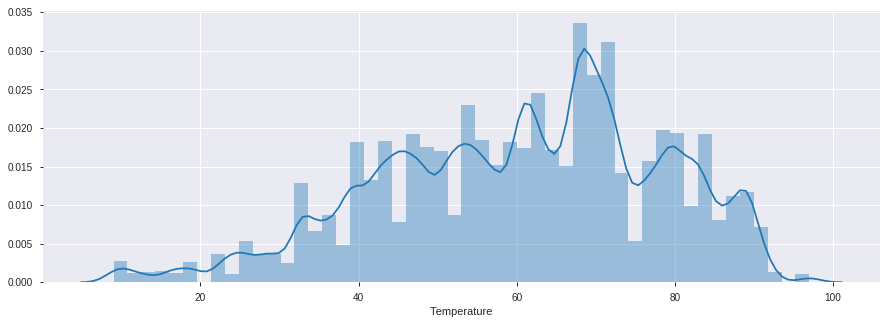

In [59]:
# temperature
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[45]].value_counts())
sns.distplot(train_df[train_df.columns[45]].dropna())

0.0     45254
70.0    28908
56.0    13420
67.0    13288
42.0    12782
        ...  
24.0     1034
14.0      968
7.0       968
29.0      902
32.0      880
Name: Humidity, Length: 86, dtype: int64


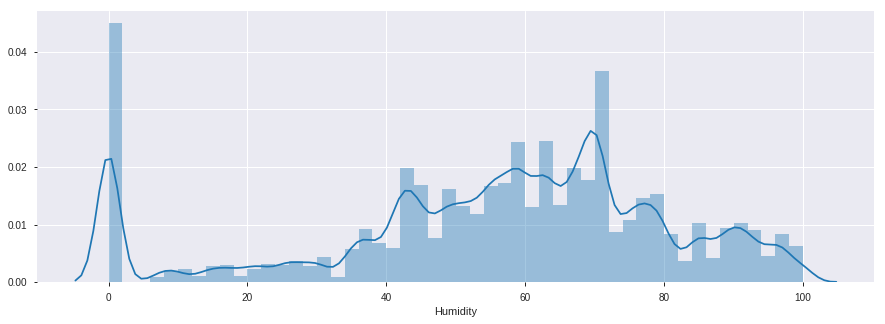

In [60]:
# humidity
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[46]].value_counts())
sns.distplot(train_df[train_df.columns[46]].dropna())

 5.0     53284
 6.0     42614
 7.0     40678
 4.0     35486
 10.0    31592
 9.0     31328
 8.0     29370
 3.0     26862
 12.0    24552
 2.0     24112
 11.0    17116
 15.0    15026
 0.0     13772
 1.0     12078
 13.0    10208
 16.0     9878
 14.0     6820
 17.0     4928
-1.0      4202
 18.0     1980
 20.0     1848
 23.0     1166
 24.0      968
 18.5      968
 22.0      836
 19.0      660
Name: WindSpeed, dtype: int64


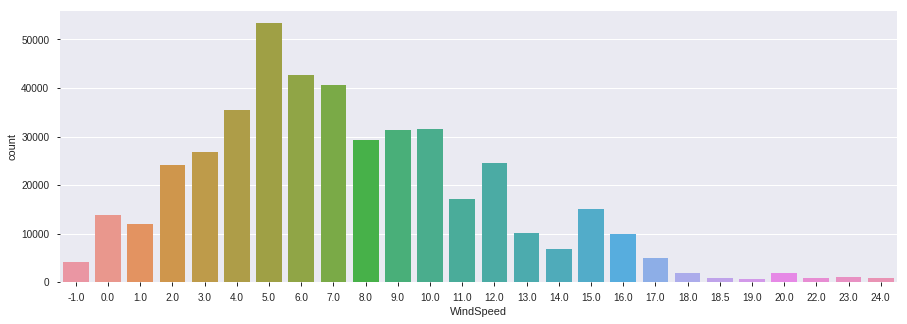

In [61]:
# windspeed
plt.figure(figsize=(15,5))
print(train_df[train_df.columns[47]].value_counts())
sns.countplot(train_df[train_df.columns[47]].dropna())

In [62]:
# WindDirection
print(train_df[train_df.columns[48]].value_counts())

unknown       321068
north east     30250
north west     27236
south west     25828
south east     25784
north          23188
west           22198
south          21384
east           12826
Name: WindDirection, dtype: int64


# new features

In [63]:
# which day is the game played
train_df["Day"] = train_df['GameId'].apply(str)
train_df["Day"] = train_df["Day"].apply(lambda x: x[:8]) 
train_df["Day"] = pd.to_datetime(train_df["Day"])
train_df["Day"] = train_df["Day"].apply(lambda x: x.weekday_name)
train_df["Day"].value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """


Sunday      434478
Thursday     33858
Monday       33726
Saturday      7700
Name: Day, dtype: int64

0.700000    130812
0.600000     92994
0.800000     64218
1.000000     16610
7.000000     14058
             ...  
0.176471        22
0.142857        22
0.160000        22
0.320000        22
1.833333        22
Name: DefendersInTheBox_vs_Distance, Length: 144, dtype: int64


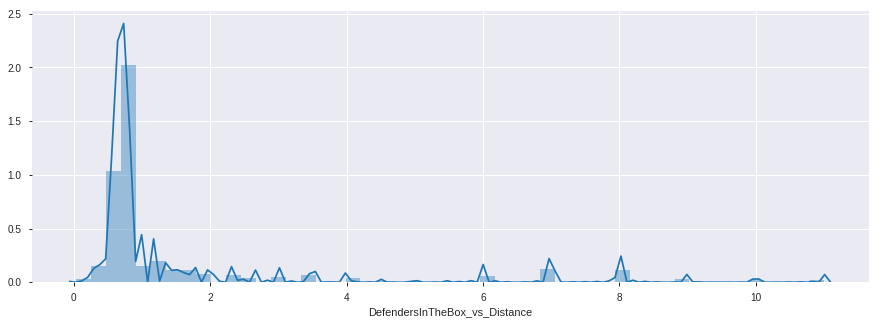

In [64]:
# DefendersInTheBox_vs_Distance #
plt.figure(figsize=(15,5))
print(train_df["DefendersInTheBox_vs_Distance"].value_counts())
sns.distplot(train_df["DefendersInTheBox_vs_Distance"].dropna())

False    486591
True      23171
Name: IsRusher, dtype: int64


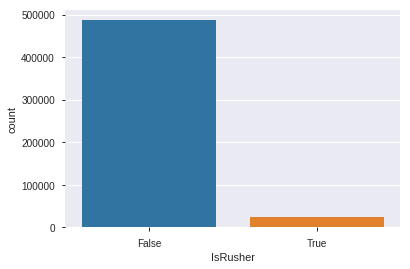

In [65]:
# Isrusher #
print(train_df["IsRusher"].value_counts())
sns.countplot(train_df["IsRusher"].dropna())

 0     114312
-7      40986
 7      35068
-3      32164
 3      28666
        ...  
-41        88
 43        66
 44        66
-43        44
 42        44
Name: Margin, Length: 85, dtype: int64


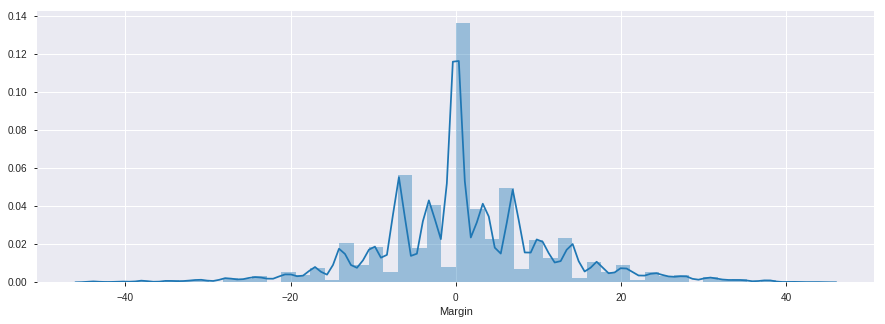

In [66]:
# margin #
plt.figure(figsize=(15,5))
print(train_df["Margin"].value_counts())
sns.distplot(train_df["Margin"].dropna())

100%|██████████| 509762/509762 [04:04<00:00, 2086.13it/s]


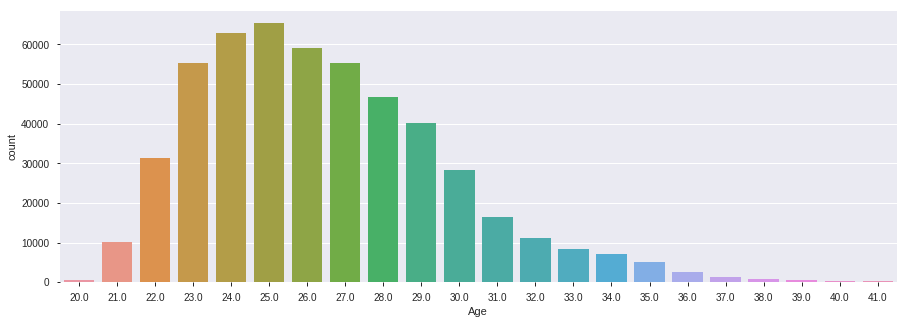

In [67]:
# Age #
FMT_birth = '%m/%d/%Y'
FMT_gamedate = '%Y-%m-%d'
gamedate = [[s for s in t.split("T")][0] for t in train_df["TimeSnap"]]
age = []
for i in tqdm.tqdm(range(train_df.shape[0])):
    tdelta = datetime.strptime(gamedate[i], FMT_gamedate) - datetime.strptime(train_df.iloc[i]["PlayerBirthDate"], FMT_birth)
    age.append(np.floor(tdelta.days/365))
train_df["Age"] = age

plt.figure(figsize=(15,5))
sns.countplot(train_df["Age"])

In [68]:
# time from snap to handoff #
FMT = '%Y-%m-%d %H:%M:%S'
tmp_time1 = [[s for s in t.split(".")][0].replace("T", " ") for t in train_df["TimeHandoff"]]
tmp_time2 = [[s for s in t.split(".")][0].replace("T", " ")  for t in train_df["TimeSnap"]]
time_diff = []
for i in range(len(tmp_time1)):
    tdelta = datetime.strptime(tmp_time1[i], FMT) - datetime.strptime(tmp_time2[i], FMT)
    time_diff.append(tdelta.seconds)
train_df["TimeFromSnapDiff"] = pd.DataFrame(time_diff)
train_df["TimeFromSnapDiff"].value_counts()

1    366784
2    137566
0      4510
3       726
4       110
7        44
5        22
Name: TimeFromSnapDiff, dtype: int64

In [69]:
# DefensePersonnelにOLも追加 #
arr = [[int(s[0]) for s in t.split(", ")] for t in train_df["DefensePersonnel"]]
train_df["DefenseDL"] = np.array([a[0] for a in arr])
train_df["DefenseLB"] = np.array([a[1] for a in arr])
train_df["DefenseDB"] = np.array([a[2] for a in arr])
train_df["DefenseOL"] = np.array([a[3] if len(a) == 4 else 0 for a in arr])

In [70]:
# OffensePersonnel #
arr = [[s for s in t.replace(" ", "").split(",")] for t in train_df["OffensePersonnel"]]
# RB, TE, WR, OL, DL, QB
RB_count = np.zeros(len(arr))
TE_count = np.zeros(len(arr))
WR_count = np.zeros(len(arr))
OL_count = np.zeros(len(arr))
DL_count = np.zeros(len(arr))
QB_count = np.zeros(len(arr))

for i in tqdm.tqdm(range(len(arr))):
    for j in range(len(arr[i])):
        if "RB" in arr[i][j]:
            RB_count[i] = int(arr[i][j][0])
        elif "TE" in arr[i][j]:
            TE_count[i] = int(arr[i][j][0])
        elif "WR" in arr[i][j]:
            WR_count[i] = int(arr[i][j][0])
        elif "OL" in arr[i][j]:
            OL_count[i] = int(arr[i][j][0])
        elif "DL" in arr[i][j]:
            DL_count[i] = int(arr[i][j][0])
        elif "QB" in arr[i][j]:
            QB_count[i] = int(arr[i][j][0])
train_df["OffenseRB"] = RB_count
train_df["OffenseTE"] = TE_count
train_df["OffenseWR"] = WR_count
train_df["OffenseOL"] = OL_count
train_df["OffenseDL"] = DL_count
train_df["OffenseQB"] = QB_count

100%|██████████| 509762/509762 [00:02<00:00, 183839.53it/s]


In [71]:
# Distance 10 #
train_df["Distance10"] = train_df["Distance"].apply(lambda x: 1 if x > 10 else 0)

In [72]:
# downとqurterを掛け合わせる #
train_df["DownQuarter"] = train_df[["Down", "Quarter"]].apply(lambda x: "D{}_Q{}".format(x[0], x[1]), axis=1)

In [73]:
# ラッシャーのスピード #
rusher_speed = np.zeros(train_df.shape[0])
game_id = list(train_df["GameId"].unique())
count_index = 0
for i in game_id:
    tmp_df = train_df[train_df["GameId"]==i]
    game_length = tmp_df.shape[0]
    rusher_speed[count_index: count_index+game_length] = np.sum(tmp_df["IsRusher"] * tmp_df["S"])
    count_index += game_length
train_df["RusherSpeed"] = rusher_speed

In [74]:
# average age in each time by each play これはデータの変形後にくっつける
print(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["S"][0::2]) # 数値で保存するときは、np.arrayでくくる
print(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["S"][1::2])

print(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["X"][0::2])
print(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["X"][1::2])

print(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["Age"][0::2])
print(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["Age"][1::2])

PlayId          Team
20170907000118  away    1.314545
20170907000139  away    1.639091
20170907000189  away    3.244545
20170907000345  away    1.555455
20170907000395  away    2.644545
                          ...   
20181230153910  away    2.779091
20181230154035  away    2.020909
20181230154082  away    2.296364
20181230154135  away    2.269091
20181230154157  away    1.992727
Name: S, Length: 23171, dtype: float64
PlayId          Team
20170907000118  home    2.106364
20170907000139  home    2.094545
20170907000189  home    3.682727
20170907000345  home    2.141818
20170907000395  home    2.322727
                          ...   
20181230153910  home    2.542727
20181230154035  home    2.816364
20181230154082  home    2.850909
20181230154135  home    2.586364
20181230154157  home    2.436364
Name: S, Length: 23171, dtype: float64
PlayId          Team
20170907000118  away    71.820909
20170907000139  away    63.438182
20170907000189  away    41.610909
20170907000345  away    10.6890

In [75]:
# 一旦結合してから変換することで、hometeam, visitorteamabbrチームのencodingルールを区別する→ちゃんと区別が必要なのか疑問になったので保留
#team_abbr = pd.concat([train_df["HomeTeamAbbr"], train_df["VisitorTeamAbbr"]], axis=0)
#team_abbr = pd.DataFrame(team_abbr, columns=["TeamAbbr"])
#team_abbr
#ce_team_change = ce.OrdinalEncoder(cols=["TeamAbbr"], handle_unknown="impute")
#team_abbr = ce_team_change.fit_transform(team_abbr)
#train_df["HomeTeamAbbr"] = team_abbr.iloc[:team_abbr.shape[0]//2, :]
#train_df["VisitorTeamAbbr"] = team_abbr.iloc[team_abbr.shape[0]//2:, :]

In [76]:
# 一旦結合してから変換することで、hometeamdivision, visitorteamdivisionのencodingルールを区別する→ちゃんと区別が必要なのか疑問になったので保留
#division_abbr = pd.concat([train_df["HomeTeamDivision"], train_df["VisitorTeamDivision"]], axis=0)
#division_abbr = pd.DataFrame(division_abbr, columns=["DivisionAbbr"])
#ce_division_change = ce.OrdinalEncoder(cols=["DivisionAbbr"], handle_unknown="impute")
#division_abbr = ce_division_change.fit_transform(division_abbr)
#train_df["HomeTeamDivision"] = division_abbr.iloc[:division_abbr.shape[0]//2, :]
#train_df["VisitorTeamDivision"] = division_abbr.iloc[division_abbr.shape[0]//2:, :]

In [77]:
# どちらのチームが勝ったのか　この新変数の計算を圧縮後のデータに対して行う
win_count = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
lose_count = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
train_df2017 = train_df[train_df["Season"] == 2017]
game_id2017 = list(train_df2017["GameId"].unique())

hometeam_wins_2017 = np.zeros(train_df2017.shape[0])
hometeam_loses_2017 = np.zeros(train_df2017.shape[0])
visitorteam_wins_2017 = np.zeros(train_df2017.shape[0])
visitorteam_loses_2017 = np.zeros(train_df2017.shape[0])

count_index = 0
for i in game_id2017:
    #print(train_df[train_df["GameId"]==i].tail(1)[["HomeTeamAbbr", "VisitorTeamAbbr", "HomeScoreBeforePlay", "VisitorScoreBeforePlay"]])
    game_length = train_df2017[train_df2017["GameId"]==i].shape[0]
    tmp_df = train_df2017[train_df2017["GameId"]==i].tail(1)
    
    # check team performance before tha game
    hometeam_wins_2017[count_index: count_index+game_length] = win_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    hometeam_loses_2017[count_index: count_index+game_length] = lose_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    visitorteam_wins_2017[count_index: count_index+game_length] = win_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    visitorteam_loses_2017[count_index: count_index+game_length] = lose_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    
    # calculate win or lose in this game
    if tmp_df["HomeScoreBeforePlay"].values[0] > tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count[tmp_df["HomeTeamAbbr"].values[0]- 1] += 1
        lose_count[tmp_df["VisitorTeamAbbr"].values[0]- 1] += 1
    elif tmp_df["HomeScoreBeforePlay"].values[0] < tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count[tmp_df["VisitorTeamAbbr"].values[0] - 1] += 1
        lose_count[tmp_df["HomeTeamAbbr"].values[0] - 1] += 1    
    
    count_index += game_length

win_count2018 = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
lose_count2018 = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
train_df2018 = train_df[train_df["Season"] == 2018]
game_id2018 = list(train_df2018["GameId"].unique())

hometeam_wins_2018 = np.zeros(train_df2018.shape[0])
hometeam_loses_2018 = np.zeros(train_df2018.shape[0])
visitorteam_wins_2018 = np.zeros(train_df2018.shape[0])
visitorteam_loses_2018 = np.zeros(train_df2018.shape[0])

count_index = 0
for i in game_id2018:
    game_length = train_df2018[train_df2018["GameId"]==i].shape[0]
    tmp_df = train_df2018[(train_df2018["GameId"]==i)].tail(1)
    
    # check team performance before tha game
    hometeam_wins_2018[count_index: count_index+game_length] = win_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    hometeam_loses_2018[count_index: count_index+game_length] = lose_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    visitorteam_wins_2018[count_index: count_index+game_length] = win_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    visitorteam_loses_2018[count_index: count_index+game_length] = lose_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    
    if tmp_df["HomeScoreBeforePlay"].values[0] > tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count2018[tmp_df["HomeTeamAbbr"].values[0]- 1] += 1
        lose_count2018[tmp_df["VisitorTeamAbbr"].values[0]- 1] += 1
    elif tmp_df["HomeScoreBeforePlay"].values[0] < tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count2018[tmp_df["VisitorTeamAbbr"].values[0] - 1] += 1
        lose_count2018[tmp_df["HomeTeamAbbr"].values[0] - 1] += 1    
        
    count_index += game_length

# homewinsbeforegame
train_df["HomeWinsBeforeGame"] = np.concatenate((hometeam_wins_2017, hometeam_wins_2018), axis=0)
train_df["HomeLosesBeforeGame"] = np.concatenate((hometeam_loses_2017, hometeam_loses_2018), axis=0)
train_df["VisitorWinsBeforeGame"] = np.concatenate((visitorteam_wins_2017, visitorteam_wins_2018), axis=0)
train_df["VisitorLosesBeforeGame"] = np.concatenate((visitorteam_loses_2017, visitorteam_loses_2018), axis=0)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

# multivariate analysis

## correlation in original data

In [78]:
# correlations of all variables
unused_columns = ["GameId","PlayId","NflId", "TimeHandoff","TimeSnap", "Location"]
check_columns = [i for i in train_df.columns if i not in unused_columns]
category_change = [i for i in train_df.columns if train_df[i].dtype=='object' and i not in unused_columns]
ce_oe = ce.OrdinalEncoder(cols=category_change, handle_unknown="impute")
train_df = ce_oe.fit_transform(train_df)
correlations = train_df[check_columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
corr_columns = ["level_0", "level_1", "value"]
correlations.columns = corr_columns
correlations = correlations.sort_values("value", ascending=False)
correlations.head(30)

,level_0,level_1,value
4691,OffenseOL,DL,0.952721
4690,DL,OffenseOL,0.952721
4689,Dis,S,0.930024
4688,S,Dis,0.930024
4687,OffenseTE,LB,0.925975
4686,LB,OffenseTE,0.925975
4685,Stadium,HomeTeamAbbr,0.923974
4684,HomeTeamAbbr,Stadium,0.923974
4683,Quarter,DownQuarter,0.887165
4682,DownQuarter,Quarter,0.887165


In [79]:
# especially high correlations
high_corr = correlations[correlations["value"]>=0.8]
remove_index = []
for i in range(high_corr.shape[0]-1):
    for j in range(i+1, high_corr.shape[0]):
        if high_corr.iloc[i]["level_0"] == high_corr.iloc[j]["level_1"] and high_corr.iloc[i]["level_1"] == high_corr.iloc[j]["level_0"]:
            remove_index.append(j)
            break
select_index = [i for i in range(high_corr.shape[0]) if i not in remove_index]
high_corr_no_duplicate = high_corr.iloc[select_index].reset_index(drop=True)
high_corr_no_duplicate

,level_0,level_1,value
0,OffenseOL,DL,0.952721
1,Dis,S,0.930024
2,OffenseTE,LB,0.925975
3,Stadium,HomeTeamAbbr,0.923974
4,Quarter,DownQuarter,0.887165
5,DB,OffenseWR,0.875936
6,DisplayName,PlayerBirthDate,0.851705


In [80]:
# correlation between target and input variables
obj_correlations = correlations[correlations['level_0'] =="Yards"].sort_values("value", ascending=False).reset_index(drop=True)
np.transpose(obj_correlations)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
level_0,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards
level_1,DefendersInTheBox,DefendersInTheBox_vs_Distance,DefenseDB,Distance,YardLine,OffenseWR,FieldvsPosession,OffenseTE,DB,LB,RusherSpeed,OffenseOL,DL,DefenseLB,Season,DefenseDL,OffensePersonnel,OffenseFormation,A,Down,NflIdRusher,OffenseDL,Distance10,VisitorTeamDivision,OL,WindSpeed,Temperature,PossessionTeam,TimeFromSnapDiff,DisplayName,VisitorTeamAbbr,DefenseOL,PlayerBirthDate,VisitorScoreBeforePlay,PlayerWeight,DefensePersonnel,OffenseRB,HomeTeamDivision,OffenseQB,JerseyNumber,PlayerHeight,DownQuarter,Quarter,Turf,HomeScoreBeforePlay,Humidity,WindDirection,Day,GameClock,HomeTeamAbbr,StadiumType,GameWeather,Week,Stadium,PlayDirection,Margin,S,Position,Orientation,X,Dir,Age,Dis,Y,PlayerCollegeName,FieldPosition,Team,IsRusher
value,0.109212,0.0842894,0.0822421,0.0719364,0.0645513,0.064406,0.0622604,0.0546731,0.0499415,0.0482206,0.0433812,0.041861,0.0409734,0.0380691,0.0313499,0.0308726,0.027488,0.0261428,0.0225919,0.0216725,0.0189973,0.0182821,0.0171307,0.0163634,0.0156745,0.0139139,0.0123671,0.0109653,0.0105436,0.00967641,0.00961973,0.00927584,0.00917021,0.00908398,0.00886179,0.00850694,0.00846894,0.00840721,0.00821567,0.00803833,0.00785715,0.00736325,0.00673313,0.00666626,0.00470593,0.00390052,0.00366836,0.00348265,0.00340924,0.00340245,0.00335809,0.00329741,0.00326473,0.00282602,0.00235793,0.00171675,0.00132751,0.0011294,0.00103377,0.000740887,0.000483461,0.000431142,0.000310282,0.000281421,0.000111316,5.37139e-05,6.27021e-18,2.73442e-18


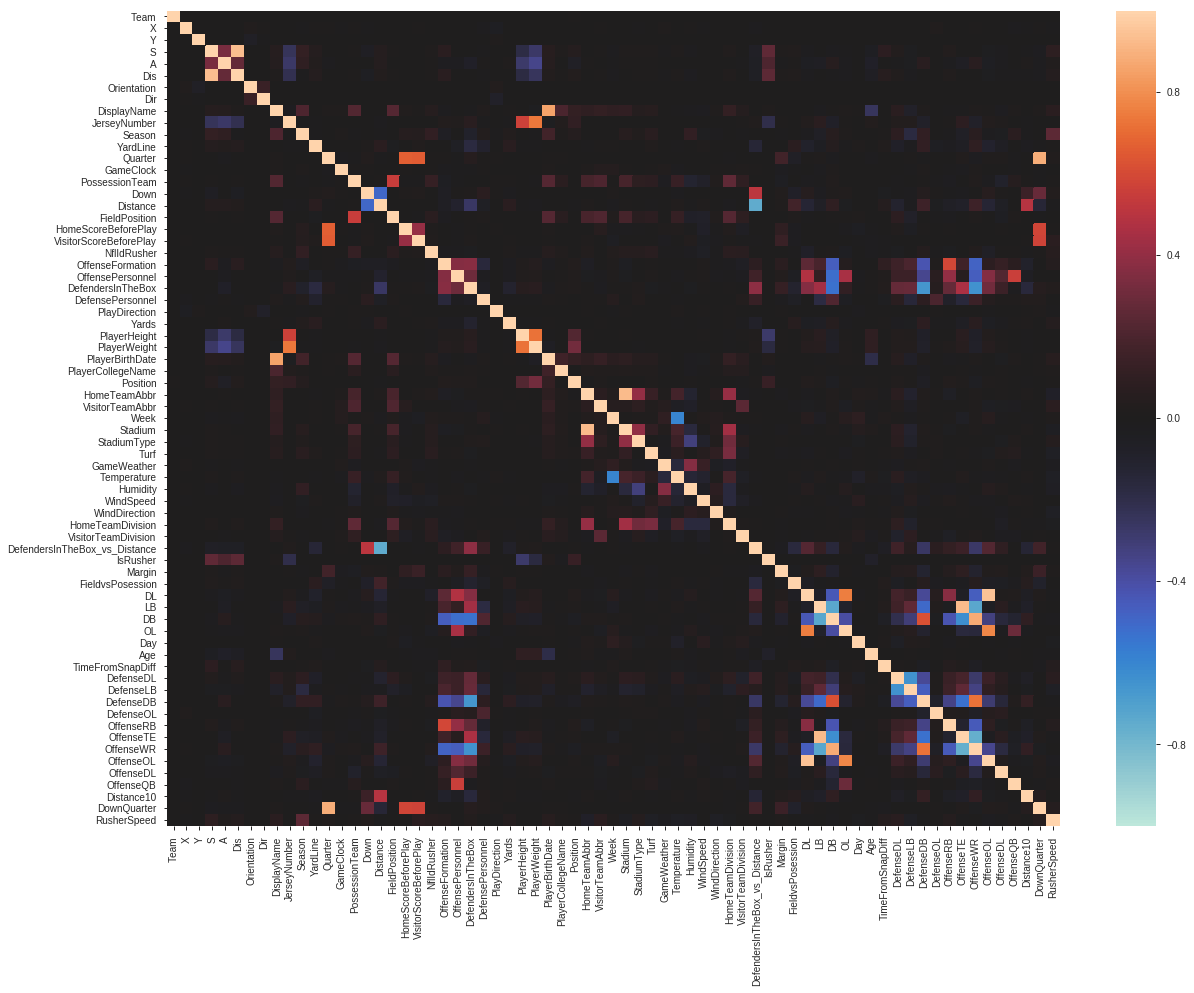

In [81]:
# heatmap
plt.figure(figsize=(20,15))
sns.heatmap(train_df[check_columns].corr(), vmax=1, vmin=-1, center=0)

## correlations in compressed data

In [82]:
# generate compressed data
unique_columns = []
for c in train_df.columns:
    if c not in unused_columns+["PlayerBirthDate"] and len(set(train_df[c][:11]))!= 1 and c not in ["NflId", "DisplayName", "JerseyNumber", "PlayerCollegeName"]:
        unique_columns.append(c)
        print(c," is unique")
unique_columns+=["IsRusher"]
unique_columns+=["Position"]
print(unique_columns)

ok = True
for i in range(0,509762,22):
    p=train_df["PlayId"][i]
    for j in range(1,22):
        if(p!=train_df["PlayId"][i+j]):
            ok=False
            break
print("train data is sorted by PlayId." if ok else "train data is not sorted by PlayId.")
ok = True
for i in range(0,509762,11):
    p=train_df["Team"][i]
    for j in range(1,11):
        if(p!=train_df["Team"][i+j]):
            ok=False
            break
print("train data is sorted by Team." if ok else "train data is not sorted by Team.")

all_columns = []
for c in train_df.columns:
    if c not in unique_columns + unused_columns+ ["DefensePersonnel","GameClock","PlayerBirthDate", "NflId", "NflIdRusher", "PlayerCollegeName", "DisplayName", "JerseyNumber"]:
        all_columns.append(c)
for c in unique_columns:
    for i in range(22):
        all_columns.append(c+str(i))
print(all_columns)

train_data=np.zeros((509762//22,len(all_columns)))
for i in tqdm.tqdm(range(0,509762,22)):
    count=0
    for c in all_columns:
        if c in train_df:
            train_data[i//22][count] = train_df[c][i]
            count+=1
    for c in unique_columns:
        for j in range(22):
            train_data[i//22][count] = train_df[c][i+j]
            count+=1        

X_train = pd.DataFrame(data=train_data,columns=all_columns)
X_train["Yards"] = np.array([train_df["Yards"][i] for i in range(0,509762,22)])

X  is unique
Y  is unique
S  is unique
A  is unique
Dis  is unique
Orientation  is unique
Dir  is unique
PlayerHeight  is unique
PlayerWeight  is unique
Position  is unique
Age  is unique
['X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'PlayerHeight', 'PlayerWeight', 'Position', 'Age', 'IsRusher', 'Position']
train data is sorted by PlayId.


  0%|          | 12/23171 [00:00<03:24, 113.52it/s]

train data is sorted by Team.
['Team', 'Season', 'YardLine', 'Quarter', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox', 'PlayDirection', 'Yards', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'HomeTeamDivision', 'VisitorTeamDivision', 'DefendersInTheBox_vs_Distance', 'Margin', 'FieldvsPosession', 'DL', 'LB', 'DB', 'OL', 'Day', 'TimeFromSnapDiff', 'DefenseDL', 'DefenseLB', 'DefenseDB', 'DefenseOL', 'OffenseRB', 'OffenseTE', 'OffenseWR', 'OffenseOL', 'OffenseDL', 'OffenseQB', 'Distance10', 'DownQuarter', 'RusherSpeed', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17

100%|██████████| 23171/23171 [03:38<00:00, 106.13it/s]


In [83]:
# correlations of all variables
unused_columns = ["GameId","PlayId","NflId", "TimeHandoff","TimeSnap", "Location"]
check_columns = [i for i in X_train.columns if i not in unused_columns]
compressed_corr = X_train[check_columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
compressed_corr = compressed_corr[compressed_corr['level_0'] != compressed_corr['level_1']]
corr_columns = ["level_0", "level_1", "value"]
compressed_corr.columns = corr_columns
compressed_corr = compressed_corr.sort_values("value", ascending=False)
np.transpose(compressed_corr.head(30))

,142997,142996,142995,142994,142993,142992,142991,142990,142989,142988,142987,142986,142985,142984,142983,142982,142980,142981,142979,142978,142977,142976,142974,142975,142973,142972,142971,142970,142969,142968
level_0,X7,X8,X18,X17,X6,X7,X13,X17,X14,X17,X1,X6,X17,X20,X3,X6,X4,X6,X16,X13,X18,X13,X6,X5,X17,X16,X19,X18,X17,X15
level_1,X8,X7,X17,X18,X7,X6,X17,X13,X17,X14,X6,X1,X20,X17,X6,X3,X6,X4,X13,X16,X13,X18,X5,X6,X16,X17,X18,X19,X15,X17
value,0.980164,0.980164,0.980081,0.980081,0.979926,0.979926,0.979908,0.979908,0.979819,0.979819,0.979792,0.979792,0.979755,0.979755,0.979738,0.979738,0.979665,0.979665,0.97965,0.97965,0.979622,0.979622,0.97962,0.97962,0.97956,0.97956,0.979469,0.979469,0.979431,0.979431


In [84]:
# especially high correlations
high_corr = compressed_corr[compressed_corr["value"]>=0.8]
remove_index = []
for i in range(high_corr.shape[0]-1):
    for j in range(i+1, high_corr.shape[0]):
        if high_corr.iloc[i]["level_0"] == high_corr.iloc[j]["level_1"] and high_corr.iloc[i]["level_1"] == high_corr.iloc[j]["level_0"]:
            remove_index.append(j)
            break
select_index = [i for i in range(high_corr.shape[0]) if i not in remove_index]
high_corr_no_duplicate = high_corr.iloc[select_index].reset_index(drop=True)
np.transpose(high_corr_no_duplicate)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
level_0,X7,X18,X6,X13,X14,X1,X17,X3,X4,X16,X18,X6,X17,X19,X17,X8,X18,X3,X18,X20,X19,X1,X4,X1,X11,X13,X17,X7,X12,X4,X14,X14,X7,X9,X1,X9,X2,X16,X2,X11,X3,X15,X8,X4,X5,X19,X19,X4,X15,X2,X16,X18,X18,X19,X13,X5,X5,X19,X3,X15,X14,X16,X15,X0,X9,X13,X12,X11,X9,X15,X9,X15,X9,X7,X12,X11,X2,X2,X0,X0,X9,X12,X11,X1,X15,X2,X4,X10,X5,X7,X3,X0,X13,X1,X3,X17,X21,X21,X10,X21,X10,X2,X10,X21,X21,X0,X15,X10,X12,X19,X6,X18,X17,X16,X17,X16,X5,X18,X6,X15,X17,X18,X13,X20,X3,X11,X3,X5,X8,X6,X18,X7,X16,X14,X11,X20,X7,X5,X16,X1,X8,X12,X8,X1,X4,X5,X20,X15,X14,X1,X1,X5,X20,X19,X1,X4,X13,X5,X20,X15,X9,X3,X4,X5,X0,X2,X1,X14,X5,X8,X2,X12,X18,X13,X12,X7,X20,X1,X8,X18,X16,X16,X4,X8,X16,X1,X5,X14,X13,X19,X8,X15,X0,X0,X14,X20,X2,X11,X20,X9,X11,X15,X2,X9,X2,X0,X12,X17,X2,X0,X9,X10,X10,X6,X7,X13,X20,X14,X21,X21,X21,X10,X12,X15,X21,X8,X10,X2,X21,X9,X21,OffenseOL,Dis21,S13,S19,S4,Dis9,Dis20,Dis14,S11,Dis12,S8,S6,Dis16,Dis3,Dis15,Dis17,Dis1,S10,S2,S0,S18,Dis7,Dis5,OffenseTE,HomeTeamAbbr,DownQuarter,OffenseWR
level_1,X8,X17,X7,X17,X17,X6,X20,X6,X6,X13,X13,X5,X16,X18,X15,X6,X16,X8,X20,X16,X17,X3,X1,X7,X18,X20,X11,X3,X17,X7,X20,X18,X5,X8,X8,X6,X8,X12,X7,X20,X4,X20,X5,X8,X1,X20,X13,X5,X16,X6,X14,X15,X12,X16,X11,X3,X2,X14,X9,X13,X12,X11,X14,X6,X4,X14,X20,X12,X7,X12,X1,X19,X5,X0,X13,X19,X1,X4,X8,X9,X2,X19,X14,X0,X11,X3,X0,X6,X0,X10,X0,X2,X21,X10,X10,X21,X18,X14,X4,X20,X8,X10,X9,X16,X11,X10,X21,X5,X21,X21,X17,X6,X7,X6,X4,X7,X17,X7,X14,X6,X1,X4,X6,X6,X17,X6,X18,X18,X17,X12,X1,X13,X4,X7,X7,X7,X15,X16,X3,X16,X16,X7,X18,X20,X14,X14,X4,X4,X3,X11,X14,X11,X5,X6,X13,X11,X3,X15,X3,X3,X17,X11,X13,X13,X17,X17,X15,X8,X12,X15,X18,X4,X0,X8,X3,X19,X8,X12,X11,X9,X9,X0,X19,X12,X2,X19,X19,X2,X0,X3,X19,X0,X20,X11,X0,X2,X13,X9,X9,X14,X2,X9,X15,X13,X12,X12,X9,X10,X19,X19,X19,X18,X16,X21,X21,X10,X10,X10,X5,X4,X3,X11,X10,X10,X1,X21,X19,X21,X0,X21,X10,DL,S21,Dis13,Dis19,Dis4,S9,S20,S14,Dis11,S12,Dis8,Dis6,S16,S3,S15,S17,S1,Dis10,Dis2,Dis0,Dis18,S7,S5,LB,Stadium,Quarter,DB
value,0.980164,0.980081,0.979926,0.979908,0.979819,0.979792,0.979755,0.979738,0.979665,0.97965,0.979622,0.97962,0.97956,0.979469,0.979431,0.979393,0.979208,0.979119,0.979097,0.979088,0.978946,0.978913,0.978834,0.978834,0.978834,0.978824,0.978805,0.978782,0.978772,0.978695,0.978694,0.978678,0.978649,0.978637,0.978603,0.978575,0.97853,0.97849,0.978462,0.978456,0.978451,0.978412,0.978398,0.978345,0.978335,0.978319,0.97831,0.978289,0.978287,0.978282,0.97828,0.978257,0.978192,0.978111,0.978098,0.97807,0.978021,0.977964,0.977897,0.977819,0.977812,0.97776,0.977687,0.97766,0.977607,0.977591,0.977541,0.9775,0.977478,0.977387,0.977382,0.977343,0.977323,0.977323,0.97731,0.976994,0.97696,0.976936,0.97693,0.976808,0.976789,0.976704,0.976677,0.976646,0.976542,0.976514,0.97629,0.976218,0.976163,0.975998,0.975917,0.975829,0.97582,0.975514,0.975453,0.975445,0.97544,0.975414,0.9752,0.975121,0.975057,0.97502,0.974792,0.974787,0.974778,0.974655,0.974547,0.974523,0.97452,0.974211,0.969637,0.969161,0.969118,0.96866,0.968399,0.96834,0.968142,0.968051,0.967969,0.967893,0.967855,0.967842,0.967819,0.967776,0.96776,0.967748,0.967693,0.967604,0.967481,0

In [85]:
# correlation between target and input variables
obj_correlations = compressed_corr[compressed_corr['level_0'] =="Yards"].sort_values("value", ascending=False).reset_index(drop=True)
np.transpose(obj_correlations)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378
level_0,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards
level_1,DefendersInTheBox,DefendersInTheBox_vs_Distance,DefenseDB,Distance,YardLine,OffenseWR,FieldvsPosession,OffenseTE,DB,LB,RusherSpeed,OffenseOL,DL,DefenseLB,A20,A21,Season,DefenseDL,A3,A17,OffensePersonnel,OffenseFormation,A10,A4,A14,A6,A5,A9,A1,A15,A13,PlayerWeight3,Down,A7,A18,A11,A12,PlayerWeight6,A19,

## plot between yards(target) and other input variables

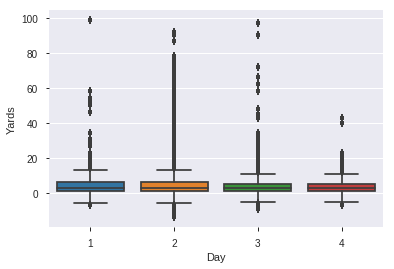

In [86]:
sns.boxplot(x="Day", y="Yards", data=train_df)
# there's no difference in yards by day

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0.5, 1.0, 'nan')

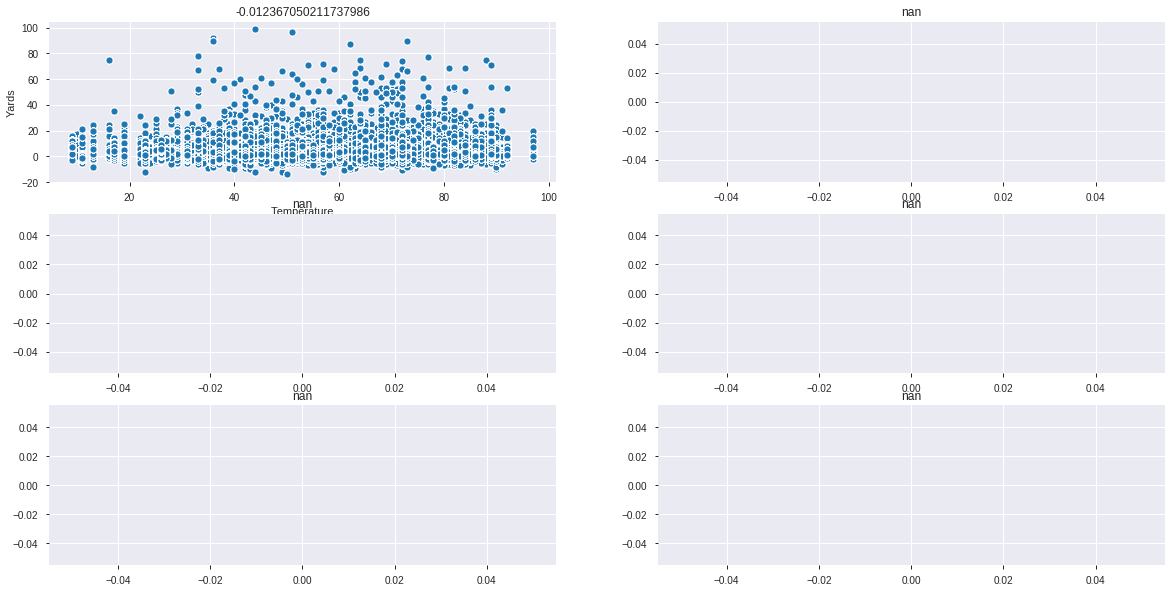

In [87]:
# yards vs stadiumtype and temperature
check_columns = ["Yards", "Temperature"]
outdoor_train = train_df[train_df.StadiumType == "outdoor"]
indooropen_train = train_df[train_df.StadiumType == "indoor open"]
indoorclose_train = train_df[train_df.StadiumType == "indoor closed"]
domeopen_train = train_df[train_df.StadiumType == "dome_closed"]
domeclose_train = train_df[train_df.StadiumType == "dome_open"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["Temperature"], train_df["Yards"])
plt.title(train_df[check_columns].corr().iloc[0,1])
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["Temperature"], outdoor_train["Yards"])
plt.title(outdoor_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["Temperature"], indooropen_train["Yards"])
plt.title(indooropen_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["Temperature"], indoorclose_train["Yards"])
plt.title(indoorclose_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["Temperature"], domeopen_train["Yards"])
plt.title(domeopen_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["Temperature"], domeclose_train["Yards"])
plt.title(domeclose_train[check_columns].corr().iloc[0,1])

Text(0.5, 1.0, 'domeclose')

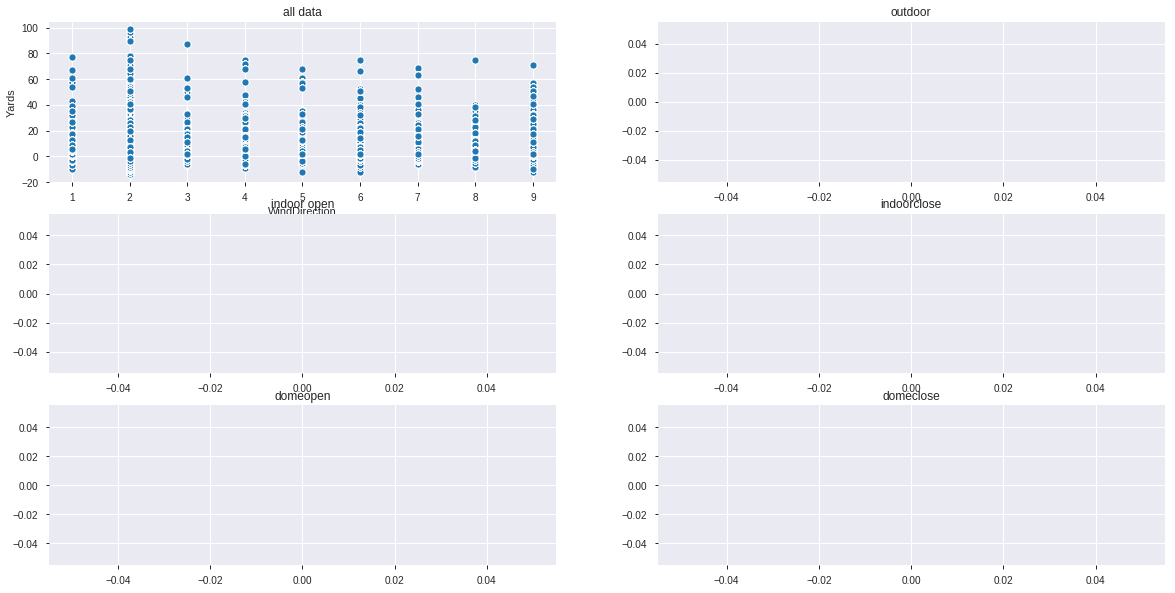

In [88]:
# yards vs stadiumtype and winddirection
check_columns = ["Yards", "WindDirection"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["WindDirection"], train_df["Yards"])
plt.title("all data")
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["WindDirection"], outdoor_train["Yards"])
plt.title("outdoor")
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["WindDirection"], indooropen_train["Yards"])
plt.title("indoor open")
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["WindDirection"], indoorclose_train["Yards"])
plt.title("indoorclose")
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["WindDirection"], domeopen_train["Yards"])
plt.title("domeopen")
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["WindDirection"], domeclose_train["Yards"])
plt.title("domeclose")

Text(0.5, 1.0, 'domeclose')

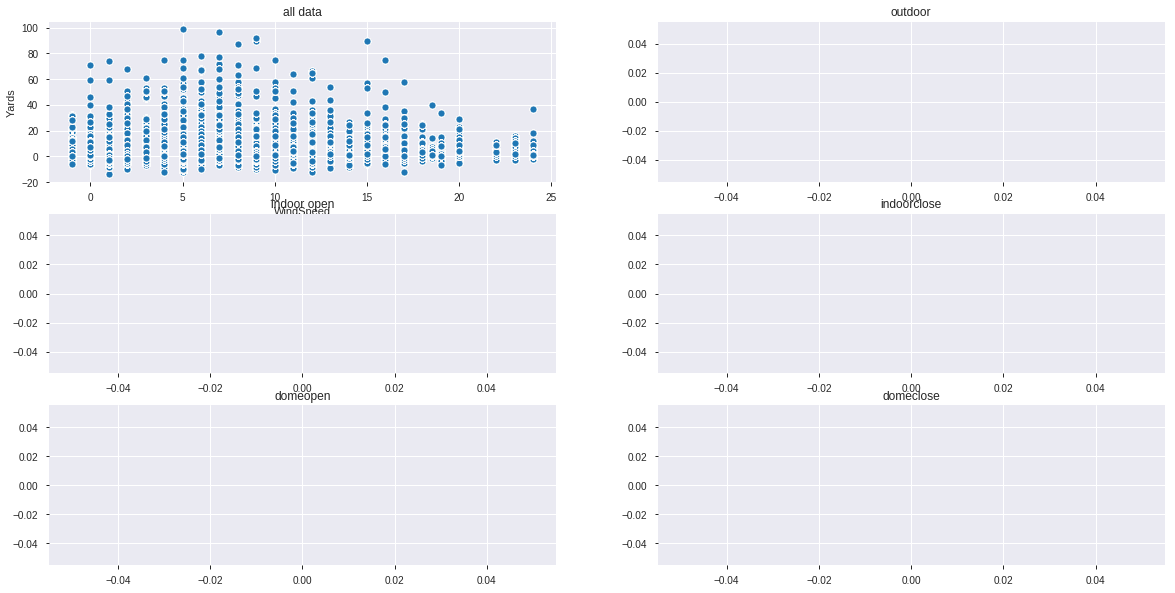

In [89]:
# yards vs stadiumtype and windspeed
check_columns = ["Yards", "WindSpeed"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["WindSpeed"], train_df["Yards"])
plt.title("all data")
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["WindSpeed"], outdoor_train["Yards"])
plt.title("outdoor")
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["WindSpeed"], indooropen_train["Yards"])
plt.title("indoor open")
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["WindSpeed"], indoorclose_train["Yards"])
plt.title("indoorclose")
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["WindSpeed"], domeopen_train["Yards"])
plt.title("domeopen")
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["WindSpeed"], domeclose_train["Yards"])
plt.title("domeclose")

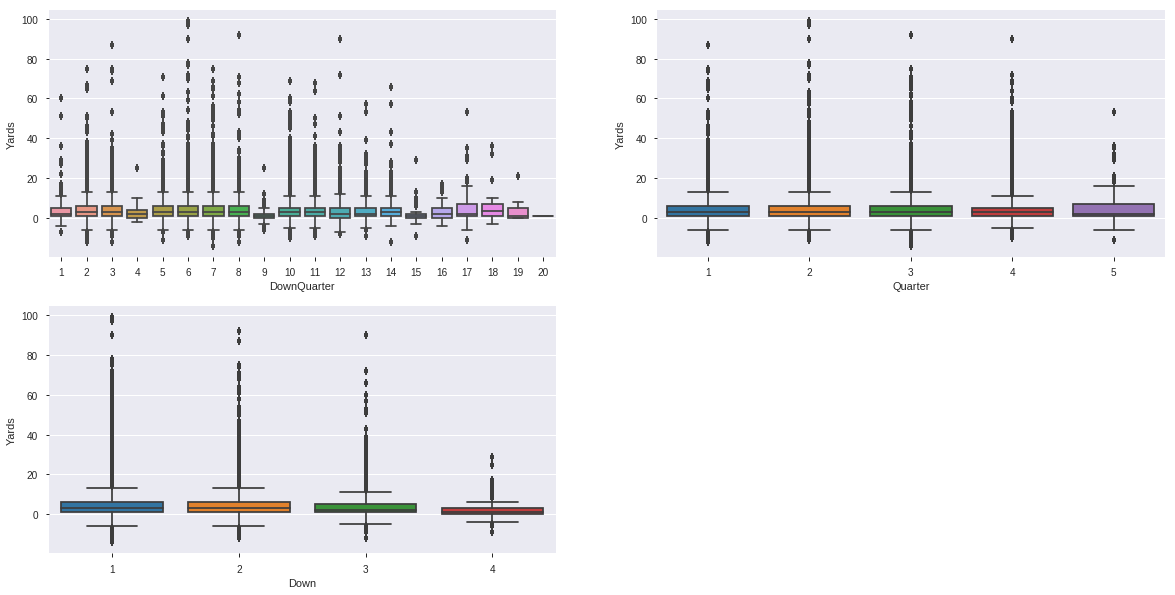

In [90]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.boxplot(train_df["DownQuarter"], train_df["Yards"])
plt.subplot(2,2,2)
sns.boxplot(train_df["Quarter"], train_df["Yards"])
plt.subplot(2,2,3)
sns.boxplot(train_df["Down"], train_df["Yards"])

In [91]:
pd.pivot_table(train_df, values="Yards", index="Down", columns="Quarter", aggfunc="mean")

Quarter,1,2,3,4,5
Down,,,,,
1,4.229977,4.519133,4.391578,4.052392,4.728972
2,4.064176,4.231695,4.355049,3.881786,5.040000
3,3.820375,4.087607,4.470032,4.078003,3.533333
4,3.000000,1.755102,3.303030,1.548387,1.000000


In [92]:
# yards vs difference of average speed between home and visitor team
tmp_df["away_S"] = np.array(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["S"][0::2])
tmp_df["home_S"] = np.array(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["S"][1::2])
tmp_df["Yards"] = np.array(train_df.groupby(["PlayId", "Team"]).agg(np.mean)["Yards"][0::2])
tmp_df["S_ave_diff"] = tmp_df["home_S"] - tmp_df["away_S"]
sns.scatterplot(tmp_df["S_ave_diff"], tmp_df["Yards"])

ValueError: Length of values does not match length of index

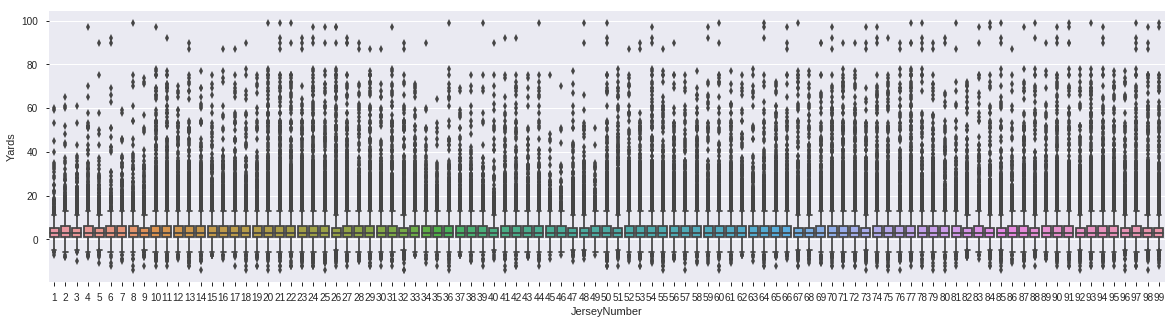

In [93]:
plt.figure(figsize=(20,5)) # 大まかには同じだが、45,46などあまり距離を稼げていない番号もありそう
sns.boxplot(train_df["JerseyNumber"], train_df["Yards"])

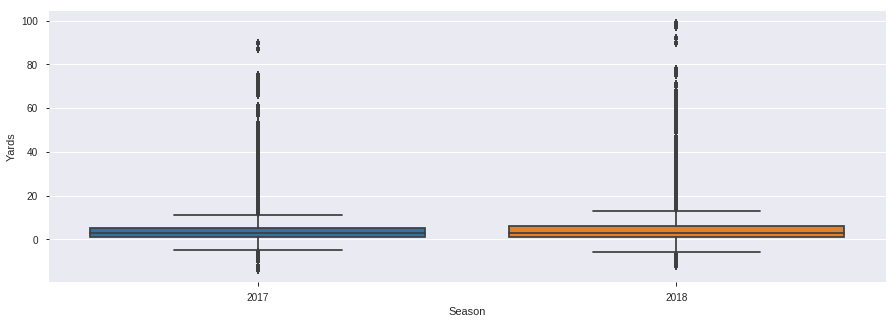

In [94]:
plt.figure(figsize=(15,5)) # there's no difference by the season
sns.boxplot(train_df["Season"], train_df["Yards"])

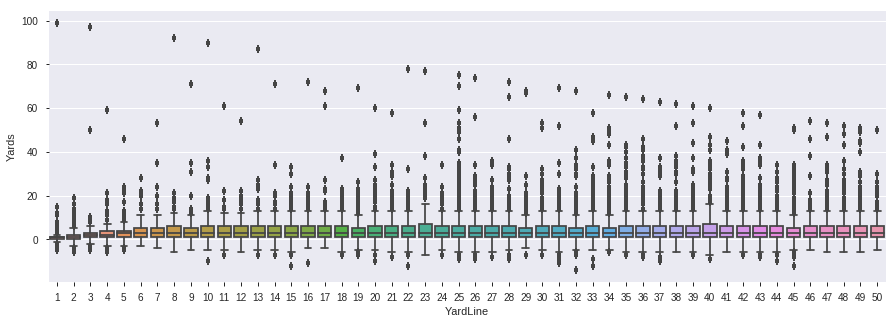

In [95]:
plt.figure(figsize=(15,5)) # clearly different
sns.boxplot(train_df["YardLine"], train_df["Yards"])

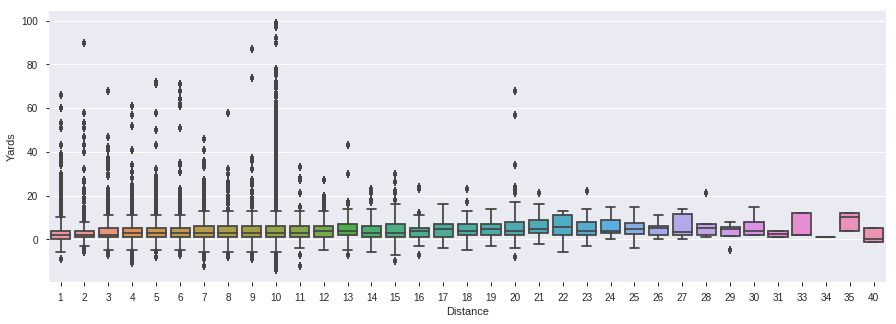

In [96]:
# Distance vs yards
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Distance"], train_df["Yards"])

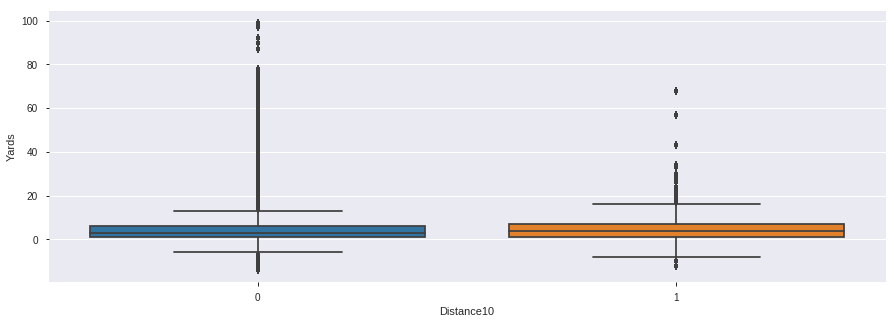

In [97]:
# Distance10 vs yards: look different
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Distance10"], train_df["Yards"])

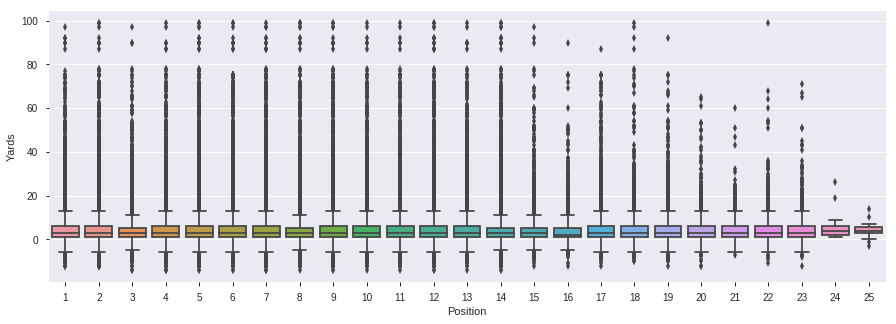

In [98]:
plt.figure(figsize=(15,5))
sns.boxplot(train_df["Position"], train_df["Yards"])

In [99]:
pd.pivot_table(train_df, values="Yards", index="Down", columns="Distance", aggfunc="mean")

Distance,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,40
Down,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.297753,0.562500,1.445946,1.578313,2.993750,2.743902,2.876543,3.295918,3.217391,4.468340,4.500000,5.000000,5.714286,6.750000,4.503876,1.625000,3.875000,3.666667,3.090909,5.110236,NaN,NaN,4.000000,5.0,3.333333,NaN,3.000000,NaN,NaN,4.666667,NaN,2.0,NaN,12.0,2.5
2,3.248991,3.604356,3.954939,3.807512,4.499276,4.129630,3.855049,4.019298,4.501075,4.721472,3.520710,4.212121,4.661972,3.431034,3.866667,4.642857,3.542857,4.931034,4.733333,6.571429,6.769231,6.454545,3.818182,4.0,5.545455,5.666667,5.666667,12.5,6.5,NaN,NaN,2.0,1.0,NaN,-1.0
3,3.373626,3.774809,5.000000,5.222222,5.322034,3.528302,4.191489,5.000000,4.972222,2.775510,4.448276,6.600000,4.807692,4.470588,7.733333,4.352941,6.200000,4.892857,6.307692,12.000000,5.111111,5.222222,9.000000,7.0,9.000000,3.750000,7.250000,4.0,-0.5,8.500000,2.5,12.0,NaN,7.0,NaN
4,2.029940,2.818182,5.250000,2.000000,6.000000,NaN,NaN,-3.000000,NaN,8.333333,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
pd.pivot_table(train_df, values="Yards", index="Dis", columns="Position", aggfunc="mean")

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Dis,,,,,,,,,,,,,,,,,,,,,,,,,
0.00,4.137931,3.674699,3.756757,4.140000,4.343195,4.221649,3.603774,4.821053,4.517241,4.441786,3.545455,3.772222,3.543353,4.105882,4.153846,2.0,6.363636,0.666667,3.190476,3.000000,NaN,3.000000,4.000000,NaN,NaN
0.01,4.613900,4.753363,5.045977,3.688022,4.647189,4.224622,3.909483,4.198953,4.297003,4.235838,4.138889,4.363636,4.462236,4.108597,3.175926,2.5,4.865854,4.812500,5.722222,5.687500,NaN,6.000000,4.166667,NaN,NaN
0.02,4.100592,4.324561,5.766667,3.765217,4.457627,3.952000,4.256881,4.324138,4.073171,4.702614,3.250000,3.540230,5.139738,4.948718,4.145833,0.5,5.093750,4.736842,4.031250,5.954545,-4.0,7.058824,7.600000,NaN,5.0
0.03,4.366492,3.980831,4.348315,3.944853,4.531128,3.893967,3.891089,3.885000,4.139651,4.461268,2.562500,3.918519,3.953069,4.053191,3.540146,NaN,6.431818,3.333333,4.666667,3.258065,NaN,2.000000,6.941176,NaN,NaN
0.04,4.475610,4.258953,4.130435,4.271293,4.880911,3.877850,3.226804,3.748387,3.897177,4.334395,5.166667,4.492784,4.362434,4.607930,4.475610,2.5,3.918367,4.363636,2.755102,2.300000,9.0,3.434783,2.812500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.10,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.13,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.16,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


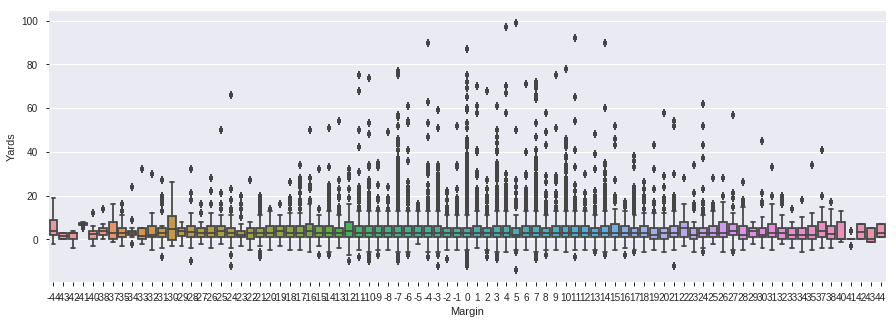

In [101]:
# margin vs yards
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Margin"], train_df["Yards"])

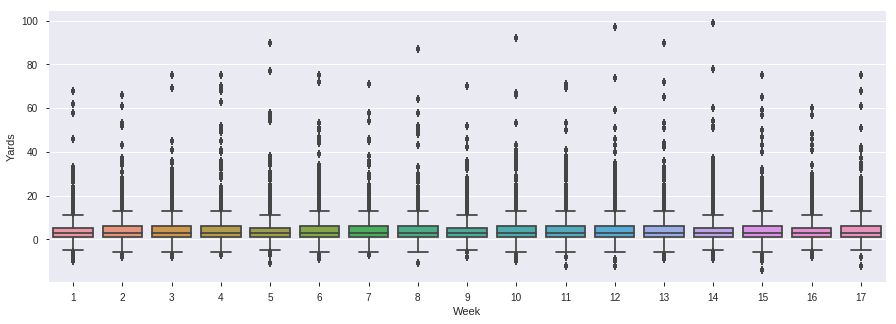

In [102]:
# week vs yards あまり関係があるように見えない
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Week"], train_df["Yards"])

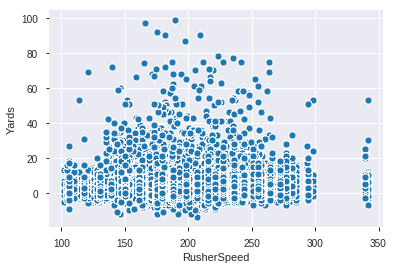

In [103]:
# rusherspeed vs yards →あまり関係なさそう
sns.scatterplot(train_df["RusherSpeed"], train_df["Yards"])

## plot between input variables

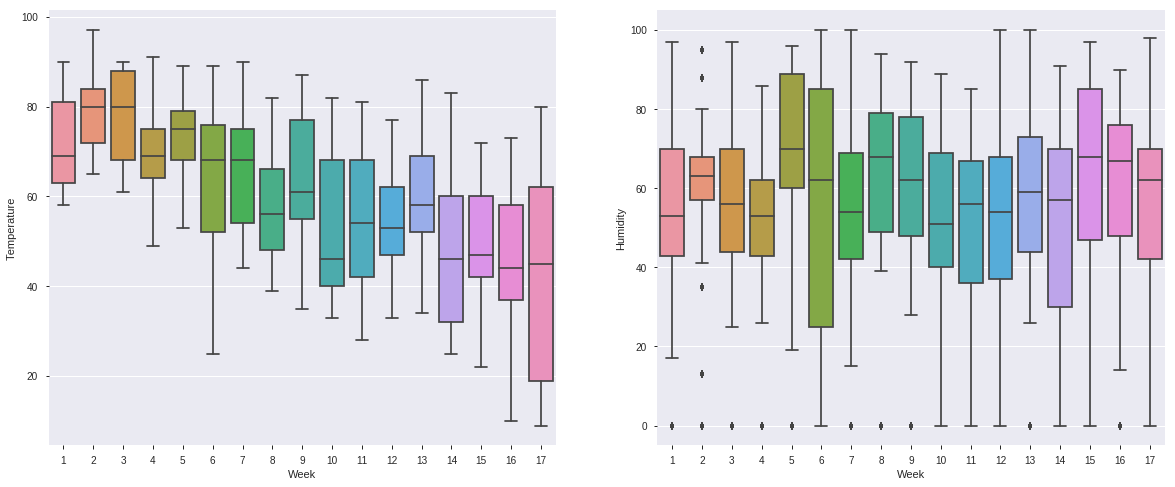

In [104]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(train_df["Week"], train_df["Temperature"])
plt.subplot(1,2,2)
sns.boxplot(train_df["Week"], train_df["Humidity"])

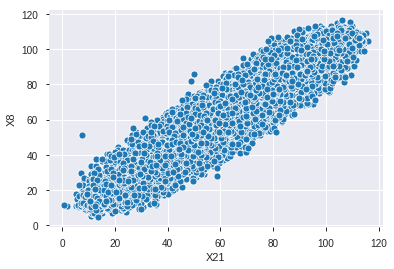

In [105]:
# X0 ~ X21までポジションの相関が異様に高い(X軸方向だと選手は大体密集しているから？)
sns.scatterplot(X_train["X21"], X_train["X8"])

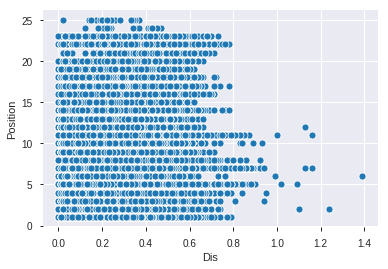

In [106]:
sns.scatterplot(train_df["Dis"], train_df["Position"])

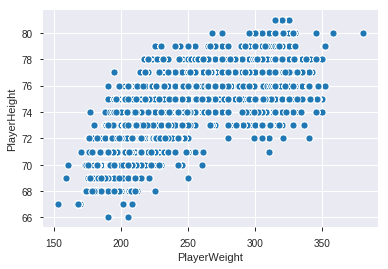

In [107]:
sns.scatterplot(train_df["PlayerWeight"], train_df["PlayerHeight"])

Home win   :  229416
Visitor win:  166034
Tie game   :  114312


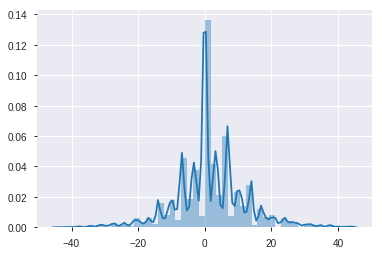

In [108]:
# score difference: almost the same, but more opportunities when home team lead the opponent
score_diff = train_df[train_df.columns[21]] - train_df[train_df.columns[22]]
print("Home win   : ", len(score_diff[score_diff > 0]))
print("Visitor win: ", len(score_diff[score_diff < 0]))
print("Tie game   : ", len(score_diff[score_diff == 0]))
sns.distplot(score_diff)

# Player position by each play

In [109]:
# variables to check each play
train_df['ToLeft'] = train_df.PlayDirection == "left" # 攻撃チームが左から右へ向かうように統一するため
train_df['Dir_std'] = np.mod(90 - train_df.Dir, 360)

(<Figure size 1728x911.52 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f113c5d3cc0>)

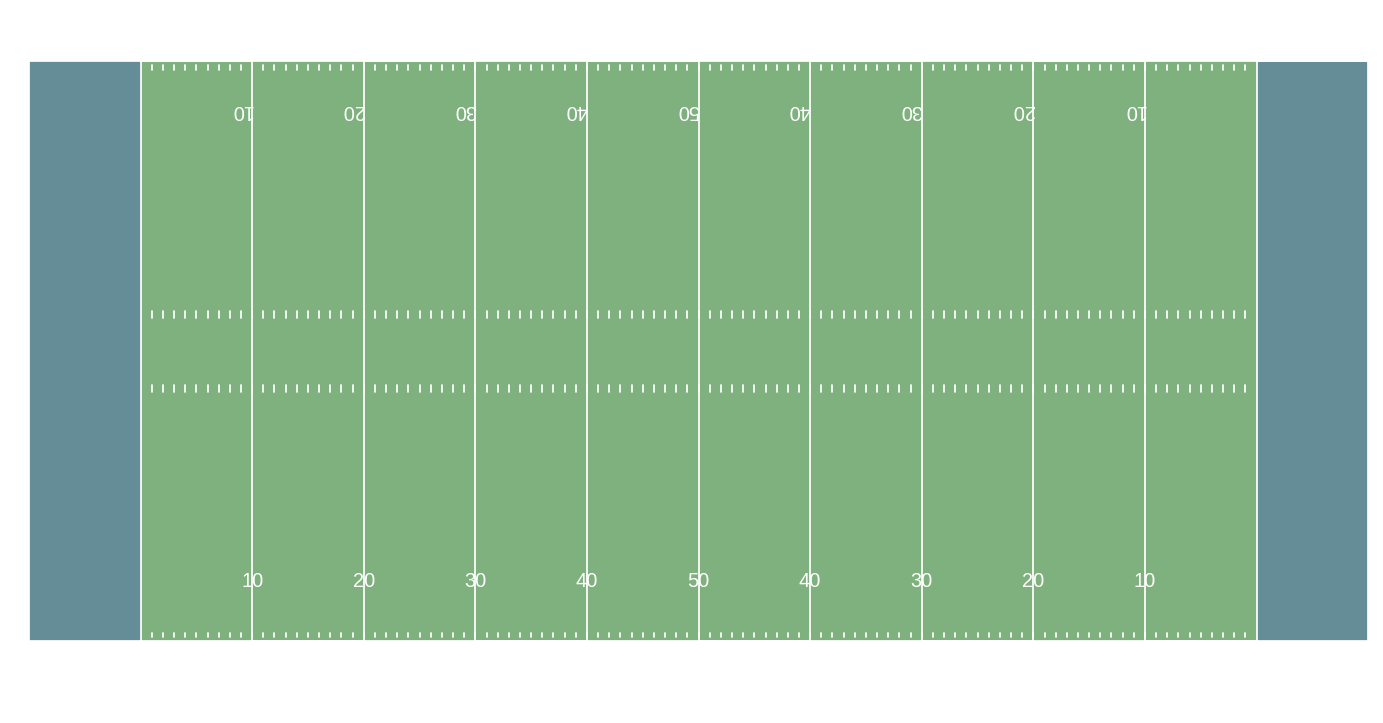

In [110]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)
        
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax
create_football_field()

In [111]:
def get_dx_dy(angle, dist):
    radian_angle = angle * math.pi/180.0
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

def show_play(play_id, train=train_df):
    plt.figure(figsize=(10,5))
    df = train_df[train_df.PlayId == play_id]
    fig, ax = create_football_field()
    ax.scatter(df.X, df.Y, cmap='rainbow', c=~(df.Team == 'home'), s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]
    x = rusher_row["X"].values[0]
    y = rusher_row["Y"].values[0]
    rusher_dir = rusher_row["Dir_std"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()

<Figure size 720x360 with 0 Axes>

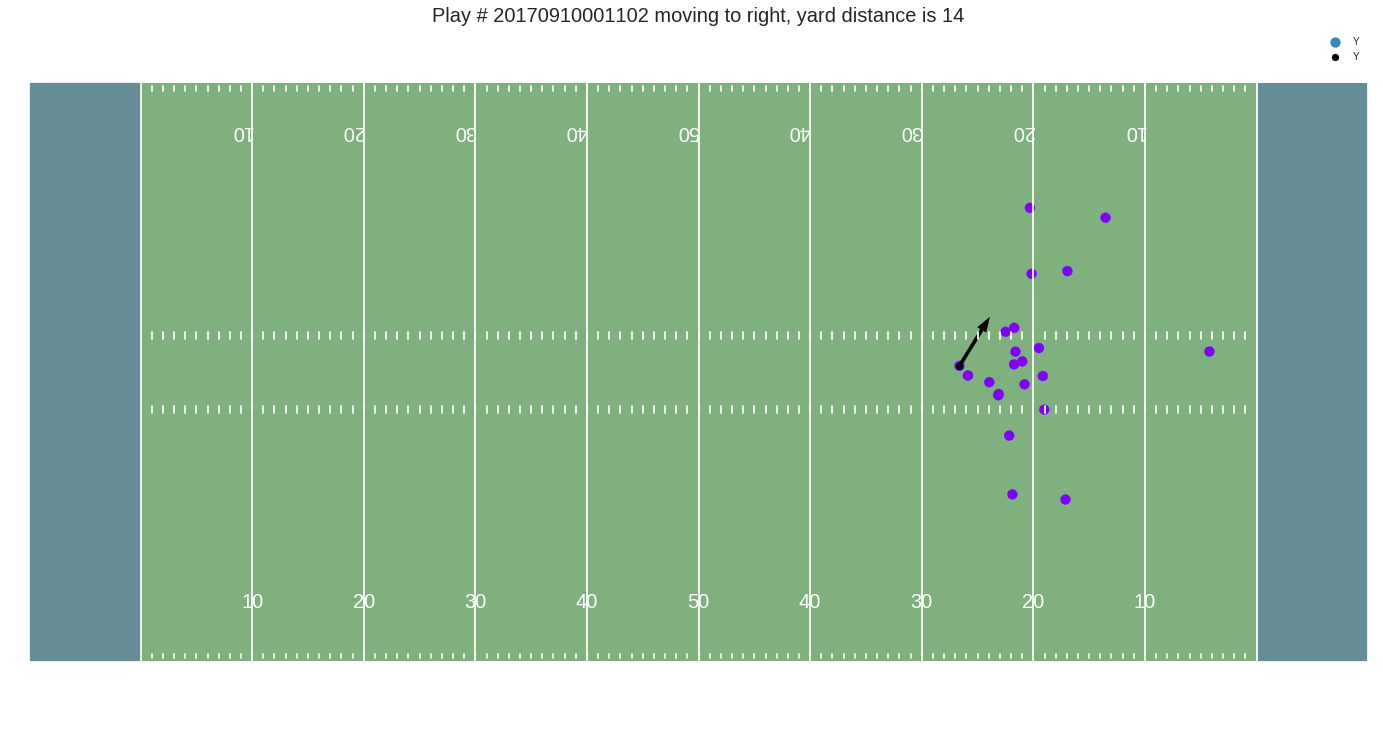

In [112]:
show_play(20170910001102)

In [113]:
train_df['TeamOnOffense'] = "home"
train_df.loc[train_df.PossessionTeam != train_df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train_df['IsOnOffense'] = train_df.Team == train_df.TeamOnOffense # Is player on offense?
train_df['YardLine_std'] = 100 - train_df.YardLine
train_df.loc[train_df.FieldPosition.fillna('') == train_df.PossessionTeam,  
          'YardLine_std'
         ] = train_df.loc[train_df.FieldPosition.fillna('') == train_df.PossessionTeam,  
          'YardLine']
train_df['X_std'] = train_df.X
train_df.loc[train_df.ToLeft, 'X_std'] = 120 - train_df.loc[train_df.ToLeft, 'X'] 
train_df['Y_std'] = train_df.Y
train_df.loc[train_df.ToLeft, 'Y_std'] = 160/3 - train_df.loc[train_df.ToLeft, 'Y'] 
train_df.loc[train_df.ToLeft, 'Dir_std'] = np.mod(180 + train_df.loc[train_df.ToLeft, 'Dir_std'], 360)

In [114]:
def show_play_std(play_id, train=train_df):
    df = train_df[train_df.PlayId == play_id]
    YardLine = df.YardLine_std.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X_std, df.Y_std, df.Dir_std, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

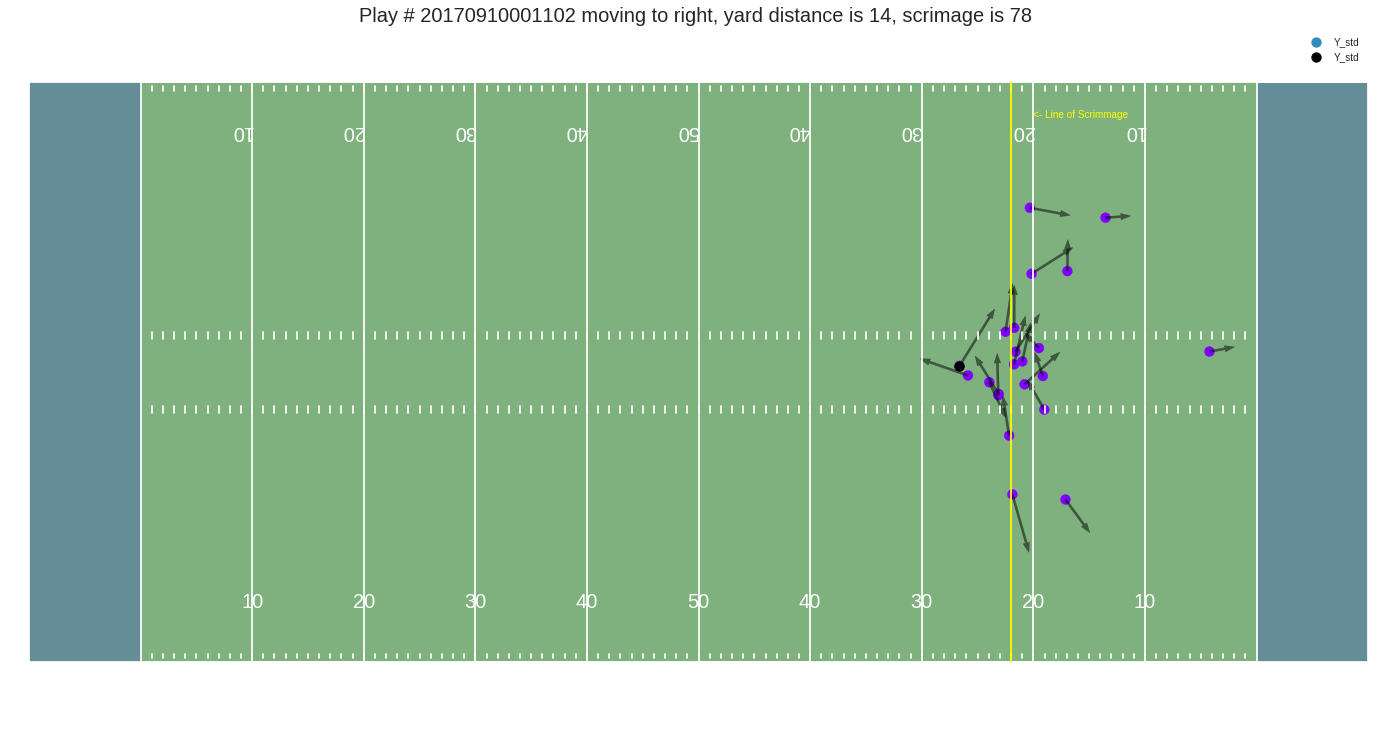

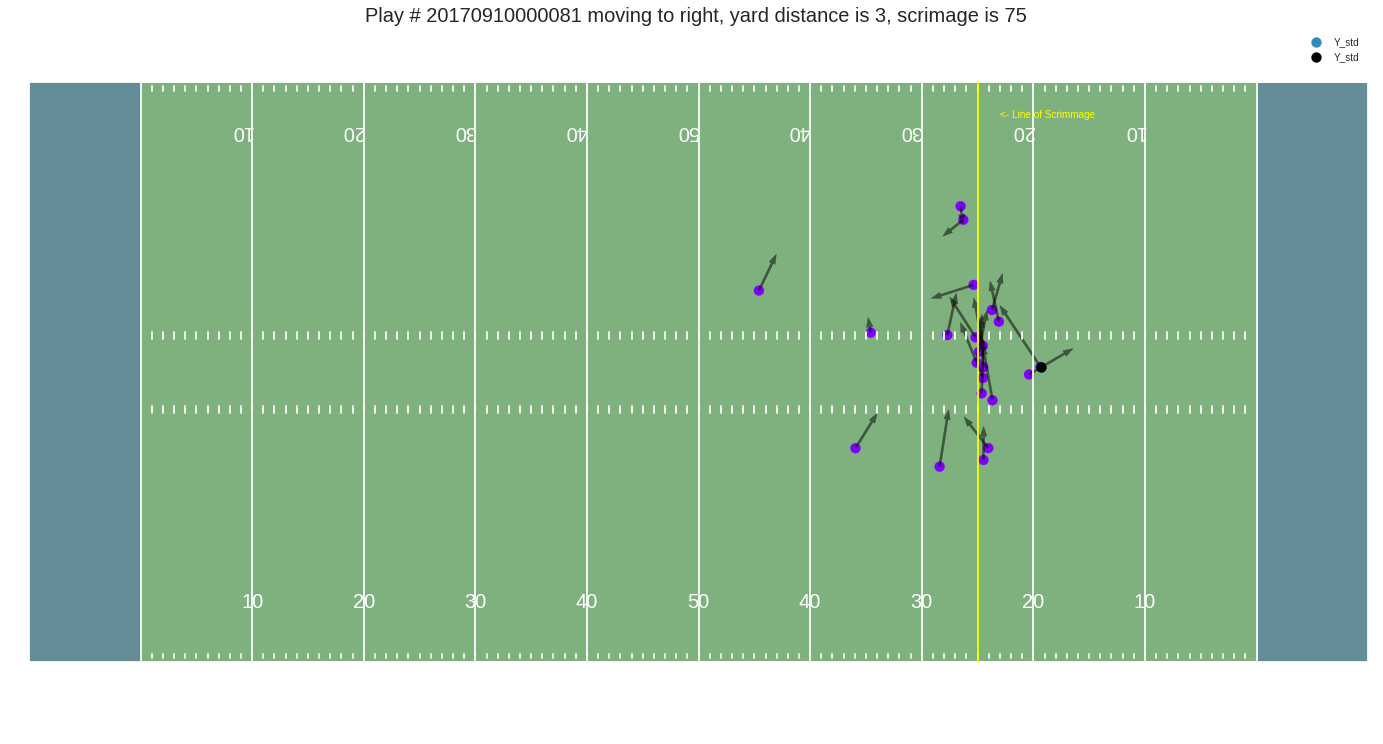

In [115]:
for play_id in [20170910001102, 20170910000081]: 
    show_play_std(play_id)

Text(0.5, 1.0, 'Carriers standardised direction')

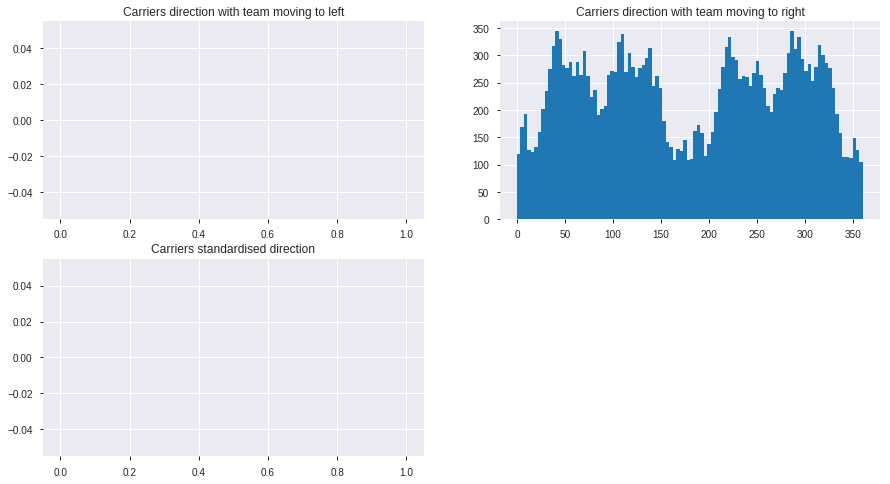

In [116]:
# let's see how standardized 
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.hist(train_df[train_df.ToLeft & train_df.IsRusher].Dir, bins=100)
plt.title('Carriers direction with team moving to left')

plt.subplot(2,2,2)
plt.hist(train_df[~train_df.ToLeft & train_df.IsRusher].Dir, bins=100)
plt.title('Carriers direction with team moving to right')

plt.subplot(2,2,3)
plt.hist(train_df[train_df.IsOnOffense & train_df.IsRusher].Dir_std, bins=100)
plt.title('Carriers standardised direction')

Text(0.5, 1.0, 'Carriers orientation with team moving to right in 2018')

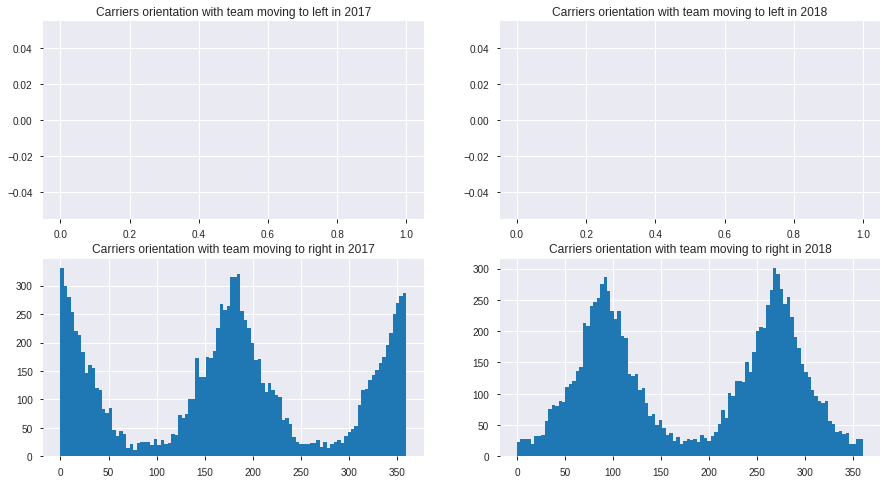

In [117]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.hist(train_df[train_df.ToLeft & train_df.IsRusher & (train_df.Season == 2017)].Orientation, bins=100)
plt.title('Carriers orientation with team moving to left in 2017')

plt.subplot(2,2,2)
plt.hist(train_df[train_df.ToLeft & train_df.IsRusher & (train_df.Season == 2018)].Orientation, bins=100)
plt.title('Carriers orientation with team moving to left in 2018')

plt.subplot(2,2,3)
plt.hist(train_df[~train_df.ToLeft & train_df.IsRusher & (train_df.Season == 2017)].Orientation, bins=100)
plt.title('Carriers orientation with team moving to right in 2017')

plt.subplot(2,2,4)
plt.hist(train_df[~train_df.ToLeft & train_df.IsRusher & (train_df.Season == 2018)].Orientation, bins=100)
plt.title('Carriers orientation with team moving to right in 2018')

In [118]:
## やること
# 既存変数の意味理解(Dir)
# 変数の作成：https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars/outputからDIrの標準化
#          https://www.kaggle.com/jaseziv83/comprehensive-cleaning-and-eda-of-all-variablesを参考に変数をkernelに組み込んだが、ローカルでは改善し、publicでは悪化した。
# →理由の検証と改善策の検討が必要。シーズンごとに向きが違っていることが影響している？
# voronoi areaの実装 https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-pythonも参考に

# 気になること
# 2017, 2018のデータで異なる部分が多いので、そのまま組み込んでよいのかと思ってしまう。(Dir, Stadiumなど)

##新変数候補
# offensepersonelの分解かつ取り込み→完了
# defencepersonnelのOLも変数として組み込む→完了
# スナップからハンドオフまでの時間→完了
# 選手の年齢とプレイ時のチーム平均年齢→完了
# のこり必要ヤード数が10より大きいかどうか→完了
# チームのこれまでの勝敗(各ゲームIDの最後を見れば、どちらが勝ったかある程度わかるはず)。当然強いチームの方が攻撃面、守備面で優れているものがあるはず。→完了
# Hometemeabbr, visitorteamabbrを別々にencodingすると、違うチームが対戦しているのに、番号が一緒になってしまうので、チームを一括でencodingしないといけない→完了
# プレーごとの選手の平均年齢、プレーごとの選手の平均ポジションX,プレーごとのチーム平均スピード→完了
# チームのリーグ、地区区分を考慮する→完了
# downとquarterで掛け合わせた変数を作る→完了
# Isruhserの速度→完了(速度が早ければランプレイで、遅ければパスしようとしていると推測していたが、プロットをみる限りあまり相関はなさそうである)